# Treatment Effect

In [1]:
# data process
import pandas as pd
import numpy as np

# plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# stats models
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import ttest_ind

# machine learning models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score, log_loss, classification_report
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer


data_folder = 'data/'
data_files = ['Study_A.csv', 'Study_B.csv', 'Study_C.csv', 'Study_D.csv', 'Study_E.csv']
raw_df = pd.concat([pd.read_csv(data_folder + f) for f in data_files])
raw_df = raw_df.set_index('AssessmentID')

print(raw_df.shape)

C:\Users\sheng\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(22909, 39)


In [2]:

def get_reliable_patients(
    raw_df, 
    nvisits=1, 
    start_visit_day_threshold=10, 
    target_visit_day_threshold=120, 
    drop_extra_columns=True
):
    """     
    This function returns a dataframe for each valid patient with:
    index:
     - Patient ID
    columns:
     - PANSS Decrease Percentage (PDP)
     - Group Label 

    A valid patient is defined as: 
     - Number of passed assessments >= nvisits; 
     - End day of all passed assessments >= target_visit_day_threshold.
     - Start day of all passed assessments <= start_visit_day_threshold
    """
    # filter LeadStatus, only 'Passed' is eligible
    raw_df = raw_df[raw_df.LeadStatus == 'Passed']
    # filter country ERROR
    raw_df = raw_df[raw_df.Country != 'ERROR']
    
    # group label: 'Control' and 'Treatment'
    labels = raw_df.TxGroup.unique()
    temp_res = {label: pd.DataFrame() for label in labels}

    # get valid patients and corresponding group label
    for label in labels:
        # new dataframe
        df = pd.DataFrame()
        
        # filter by visit day
        grouped = raw_df[raw_df.TxGroup == label].groupby('PatientID')['VisitDay']
        df['visit_start_day'] = grouped.agg('min')
        df['visit_end_day'] = grouped.agg('max')
        df['visit_count'] = grouped.agg('count')
        df['TxGroup'] = label
        df = df[(
            df.visit_count >= nvisits) 
            & (df.visit_start_day <= start_visit_day_threshold) 
            & (df.visit_end_day >= target_visit_day_threshold)]

        temp_res[label] = df
        
    valid_pats = pd.concat([df for label, df in temp_res.items()])

    # calculate evaluation score
    grouped = raw_df.merge(valid_pats, how='inner', on='PatientID').groupby('PatientID')[['VisitDay', 'PANSS_Total']]
    
    def get_target_visit(df):
        df = df.sort_values('VisitDay')
        df = df[df.VisitDay >= target_visit_day_threshold]
        if not df.empty:
            return df.iloc[0]

    target_visit_df = grouped.apply(get_target_visit)
    valid_pats['visit_target_day'] = target_visit_df['VisitDay']
    valid_pats['PANSS_target'] = target_visit_df['PANSS_Total']

    start_visit_df = grouped.apply(lambda df: df.sort_values('VisitDay').iloc[0])
    valid_pats['PANSS_start'] = start_visit_df['PANSS_Total']

    valid_pats['PANSS_decrease_pct'] = (valid_pats['PANSS_start'] - valid_pats['PANSS_target']) / valid_pats['PANSS_start']
    if drop_extra_columns:
        valid_pats = valid_pats.drop(columns=[
            'visit_start_day','visit_end_day','visit_count','visit_target_day','PANSS_target','PANSS_start'
        ])

    return valid_pats

def plot_samples(valid_pats, show_fig=False, save_fig_as=False):

    f, axs = plt.subplots(1,5, figsize=(20,4))

    # split data by group
    control = valid_pats[valid_pats.TxGroup == 'Control']['PANSS_decrease_pct']
    treat = valid_pats[valid_pats.TxGroup == 'Treatment']['PANSS_decrease_pct']

    # distribution plot
    sns.distplot(control, ax=axs[0],bins=10, label= 'Control')
    sns.distplot(treat, ax=axs[0],bins=10, label= 'Treatment')
    axs[0].set_title('Dsitribution', fontsize=16);
    axs[0].set_xlabel('PANSS Decrease Pct', fontsize=12);
    axs[0].legend();

    # boxplot
    valid_pats.boxplot('PANSS_decrease_pct', by='TxGroup', fontsize=16, ax= axs[1]);
    axs[1].get_figure().suptitle("");
    axs[1].set_title('PANSS Decrease Pct', fontsize=16);
    axs[1].set_xlabel('Groupy Label', fontsize=12);

    # QQ plot for control group
    qqplot(control, line='s', ax=axs[2]);
    axs[2].set_title('Q-Q Plot for Control Group', fontsize=16);
    
    # QQ plot for treatment group
    qqplot(treat, line='s', ax=axs[3]);
    axs[3].set_title('Q-Q Plot for Treatment Group', fontsize=16);
    
    # plot patient count of each group
    df = valid_pats.groupby('TxGroup').count()
    df.plot.bar(ax=axs[4], legend=False, rot=0)
    for i, v in enumerate(df['PANSS_decrease_pct']):
        axs[4].text(i - 0.1, v + 5, str(v), color='black', fontweight='bold')
    axs[4].set_title('Count of Patients', fontsize=16)
    axs[4].set_xlabel('Groupy Label', fontsize=12)
    
    if save_fig_as:
        f.savefig(save_fig_as, bbox_inches = 'tight')
        
    if not show_fig:
        plt.close()
    
    return

def hypo_test(valid_pats, alpha=0.05, alternative='two-sided'):
    '''
    H0: mean PANSS decrease of both groups are identical
    H1: mean PANSS decrease of both groups are not identical
    '''    
    # data for each group
    control = valid_pats[valid_pats.TxGroup == 'Control']['PANSS_decrease_pct']
    treat = valid_pats[valid_pats.TxGroup == 'Treatment']['PANSS_decrease_pct']
    
    # Student's t-test
    stat, p = ttest_ind(treat, control)
    print('Student\'s T Test: stat=%.3f, p=%.3f' % (stat, p))
    print(f'significant level: {alpha}')
    if p > alpha:
        print(f'No significant difference between Treatment Group and Control Group.')
    else:
        print(f'Treatment Group shows significant difference from Control Group.')
        
    return stat, p


def evaluate_treatment_effect(raw_df, nvisits=1, start_visit_day_threshold=10, target_visit_day_threshold=120, show_fig=False, save_fig=True):
    # get patients with reliable PANSS decreases
    pats = get_reliable_patients(raw_df, nvisits, start_visit_day_threshold, target_visit_day_threshold)
    
    # parameters of treatment effect evaluation
    print('-----------------------------------------')
    print(f'Evaluating Treatment Effect of Day {target_visit_day_threshold}')
    print(f'======== Parameters ========')
    print(f'nvisits = {nvisits}')
    print(f'start_visit_day_threshold  = {start_visit_day_threshold}')
    print(f'target_visit_day_threshold = {target_visit_day_threshold}\n')    
    
    # plot the PANSS decrease by group
    print('======== Distribution Check ========')
    print(pats.groupby('TxGroup').agg(['mean', 'std', 'var']).round(3))
    plot_samples(pats,show_fig=show_fig, save_fig_as=f'effect_day_{target_visit_day_threshold}.jpg')
    print(f'Plots saved as effect_day_{target_visit_day_threshold}.jpg\n')
    
    # hypothesis test
    print('======== Hypothesis Test ========')
    stat, p = hypo_test(pats)
    print('Hypothesis test done.\n')
    
    return pats, (stat, p)

In [19]:
target_days = [60, 120, 180, 240, 300, 360]
for day in target_days:
    _ = evaluate_treatment_effect(raw_df, target_visit_day_threshold=day)

-----------------------------------------
Evaluating Treatment Effect of Day 60
======== Parameters ========
nvisits = 1
start_visit_day_threshold  = 10
target_visit_day_threshold = 60

======== Distribution Check ========
          PANSS_decrease_pct              
                        mean    std    var
TxGroup                                   
Control                0.201  0.155  0.024
Treatment              0.204  0.150  0.022
Plots saved as effect_day_60.jpg

======== Hypothesis Test ========
Student's T Test: stat=0.357, p=0.721
significant level: 0.05
No significant difference between Treatment Group and Control Group.
Hypothesis test done.

-----------------------------------------
Evaluating Treatment Effect of Day 120
======== Parameters ========
nvisits = 1
start_visit_day_threshold  = 10
target_visit_day_threshold = 120

======== Distribution Check ========
          PANSS_decrease_pct              
                        mean    std    var
TxGroup                      

# Patient Segmentation

In [3]:

def data_prepare(raw_df):
    df = raw_df[
        (raw_df.LeadStatus == 'Passed') 
        & (raw_df.Country != 'ERROR') 
        & (raw_df.VisitDay == 0)]

    df = df.groupby('PatientID').apply(lambda df: df.iloc[0])

    positive_cols = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
    negative_cols = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
    general_cols = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16']

    df['Positive'] = df[positive_cols].sum(axis=1)
    df['Negative'] = df[negative_cols].sum(axis=1)
    df['General'] = df[general_cols].sum(axis=1)
    df['Composite'] = df['Positive'] - df['Negative']

    sum_score_cols = ['Positive', 'Negative', 'General', 'Composite', 'PANSS_Total']

    feats_clustering = positive_cols + negative_cols + general_cols + sum_score_cols

    df = df[feats_clustering]
    return df, sum_score_cols

def score_distribution(df, score_columns, show_fig=False, save_fig=True):
    dfm = df[score_columns].melt(var_name='columns')
    g = sns.FacetGrid(dfm, col='columns')
    g = (g.map(sns.distplot, 'value'))

    if save_fig:
        g.savefig('score_distribution.jpg')
    if not show_fig:
        plt.close()
        
        
def pca_n_components_selection(df, show_fig=False, save_fig_as=False):
    scaler = StandardScaler()
    pca = PCA()
    X = scaler.fit_transform(df)
    X = pca.fit_transform(X)
    evrcs = pca.explained_variance_ratio_.cumsum()
    
    if save_fig_as or show_fig:
        fig = plt.figure()
        plt.plot(range(1, 1+len(evrcs)),evrcs);
        plt.title('PCA', fontsize=20)
        plt.xlabel('Number of Principle Components', fontsize=16)
        plt.ylabel('Explained Variance Percentage', fontsize=16)
        plt.tight_layout()

        if save_fig_as:
            plt.savefig(save_fig_as, bbox_inches = 'tight')

        if not show_fig:
            plt.close()
        
    n_components = 1 + (pca.explained_variance_ratio_.cumsum() < 1).sum()
    return n_components

def plot_patient_distribution(df, show_fig=False, save_fig=False):
    f = plt.figure(figsize=(20,4))
    #f.subplots_adjust(left=0.01)
    f.tight_layout()
    
    # P, N, G 3D plot
    ax = f.add_subplot(1,4,1, projection='3d')
    ax.scatter(df['Positive'], df['Negative'], df['General'])
    ax.set_xlabel('Positive')
    ax.set_ylabel('Negative')
    ax.set_zlabel('General')
    ax.set_title('P/N/G Score')
    ax.view_init(elev=30, azim=45)
    #ax.dist = 15
    
    # composite and total score plot
    ax = f.add_subplot(1,4,2)
    ax.scatter(df['Composite'], df['PANSS_Total'])
    ax.set_xlabel('Composite')
    ax.set_ylabel('PANSS_total')
    ax.set_title('Composite vs PANSS Total')

    
    # PCA 2D plot
    processor = make_pipeline(
        StandardScaler(), 
        PCA(n_components=2))
    X = processor.fit_transform(df)
    ax = f.add_subplot(1,4,3)
    ax.scatter(X[:, 0], X[:, 1])
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title('PCA')

    
    # t-SNE 2D plot
    processor = make_pipeline(
        StandardScaler(), 
        PCA(n_components=pca_n_components_selection(df, show_fig=False, save_fig_as=False)),
        TSNE(
            n_components=2, 
            init='pca', 
            perplexity=30,
            learning_rate=300,
            random_state=42,
            n_jobs=-1))
    X = processor.fit_transform(df)
    ax = f.add_subplot(1,4,4)
    ax.scatter(X[:, 0], X[:, 1])
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title('t-SNE')  
    
    # write figure to file
    if save_fig:
        f.savefig('patient_scattering.jpg')
        
    if not show_fig:
        plt.close()
    
def feature_and_model_selection(
    df, algo, 
    features=None, 
    range_n_clusters=range(2,10), 
    pca_show_fig=False, 
    pca_save_fig_as=False,
    cluster_show_fig=False,
    cluster_save_fig_as=False
):

    # feature selection
    if features:
        df = df[features]
    
    # data process
    precessor = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(pca_n_components_selection(
            df, 
            save_fig_as=pca_save_fig_as,
            show_fig=pca_show_fig
        )))
    ])
    X = precessor.fit_transform(df)


    # Find optimal n_clusters: 1. Model selection
    models = []
    sse = []
    cms = []
    for n_clusters in range_n_clusters:
        if algo == 'K Means':
            model = KMeans(
                n_clusters=n_clusters, 
                init='k-means++', 
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=42
            )

            model = model.fit(X)

            models.append(model)
            sse.append(model.inertia_)
            cms.append(silhouette_score(X, model.labels_, metric='euclidean'))
            
        elif algo == 'Agglomerative':
            model = AgglomerativeClustering(
                n_clusters=n_clusters, 
                affinity='euclidean', 
                linkage='ward'       
            )

            model = model.fit(X)
            y = model.labels_
            
            # calculate SSE
            sse_temp = 0
            for label in range(model.n_clusters_):
                X_group = X[y == label]
                centroid = X_group.mean(axis=0).reshape(1,-1)
                sse_temp += pairwise_distances(X_group, centroid, metric='euclidean').sum()

            models.append(model)
            sse.append(sse_temp)
            cms.append(silhouette_score(X, y, metric='euclidean'))
    

    # Find the optimal K: 2. Elbow Method
    fig, ax1 = plt.subplots();

    ax2 = ax1.twinx()
    ax1.plot(range_n_clusters, sse, 'g-')
    ax2.plot(range_n_clusters, cms, 'b-')

    ax1.set_xlabel('Number of Clusters', fontsize=20)
    ax1.set_ylabel('SSE', fontsize=20, color='g')
    ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
    ax1.set_title(f'{algo}', fontsize=20)
    
    plt.tight_layout()
    
    if cluster_save_fig_as:
        fig.savefig(cluster_save_fig_as, bbox_inches = 'tight');
 
    if not cluster_show_fig:
        plt.close()
    

def cluster_characteristics(df, show_fig=False, save_fig_as='cluster_characteristics.jpg'):

    # characteristics plot (aka Snake Plot)
    ## Normalization
    scaler = MinMaxScaler()
    df_normlized = pd.DataFrame(
        scaler.fit_transform(df[sum_score_cols]), 
        columns=df[sum_score_cols].columns,
        index=df[sum_score_cols].index
    )
    ## assgin labels
    df_normlized['cluster_label'] = df['cluster']
    ## process data for plotting
    df_melted = pd.melt(
        df_normlized.reset_index(),
        id_vars=['PatientID', 'cluster_label'], 
        value_vars=['Positive', 'Negative', 'General', 'Composite','PANSS_Total'],
        var_name='Attribute',
        value_name='Value'
    )merg

    # relative importance of each feature in each cluster
    df_sum_score = df[sum_score_cols].copy()
    df_sum_score['cluster_label'] = df['cluster']
    cluster_avg_K6 = df_sum_score.groupby('cluster_label').mean()
    population_avg = df[sum_score_cols].mean()
    relative_imp = cluster_avg_K6 / population_avg - 1
    
    # dataframe to return
    df_return = cluster_avg_K6.append(population_avg.to_frame().rename(columns={0:'population'}).transpose())

    # plot figures
    if save_fig_as or show_fig:
        
        f, axs = plt.subplots(1,2, figsize=(12,5))
        
        # characteristics plot
        sns.lineplot(
            x='Attribute',
            y='Value',
            hue='cluster_label',
            data=df_melted,
            legend='full',
            markers=True,
            ax=axs[0]
        );
        axs[0].set_title('Cluster Characteristics',fontsize=20);
        axs[0].set_ylim(top=1);
        axs[0].legend(loc='upper center', ncol=3, fancybox=True, shadow=True);

        # relative importance plot
        sns.heatmap(
            data=relative_imp,
            annot=True,
            ax=axs[1],
            cmap='RdYlGn'
        );
        axs[1].set_title('Relative Importance',fontsize=20);
        
        # write to file
        if save_fig_as:
            f.savefig(save_fig_as, bbox_inches = 'tight')
            
        if not show_fig:
            plt.close()

            
    return df_return

SyntaxError: invalid syntax (<ipython-input-3-d92d51b565a3>, line 229)

In [5]:
########################
# Patient Segmentation #
########################
print('######### Task 2: Patient Segmentation ###########')

# data preparation      
df, sum_score_cols = data_prepare(raw_df)
print(f'Data Processed. Shape of data: {df.shape}')

# plot distribution of scores
score_distribution(df, sum_score_cols, show_fig=False, save_fig=True)
print('Feature distribution checked. Figures saved to disk.')

# scatter plots of PANSS ratings and scores
plot_patient_distribution(df, show_fig=False, save_fig=True)
print('Scatter plot of PANSS scores is done and saved to disk.')

# feature selection and model selection
print('Selecting features and models...')

## 35 features + K Means
feature_and_model_selection(
    df, 'K Means', 
    pca_save_fig_as='segment_pca_35_features.jpg', 
    cluster_save_fig_as='segment_kmeans_35_features.jpg')
print('Model fitted: 35 features + K Means')

## 5 features + K Means
feature_and_model_selection(
    df, 'K Means', features=sum_score_cols, 
    pca_save_fig_as='segment_pca_5_scores.jpg', 
    cluster_save_fig_as='segment_kmeans_5_scores.jpg')
print('Model fitted: 5 features + K Means')

## 35 features + Agglomerative
feature_and_model_selection(
    df, 'Agglomerative', 
    cluster_save_fig_as='segment_agglo_35_fetures.jpg')
print('Model fitted: 35 features + Agglomerative Clustering')

## 5 features + Agglomerative
feature_and_model_selection(
    df, 'Agglomerative', features=sum_score_cols, 
    cluster_save_fig_as='segment_agglo_5_scores.jpg')
print('Model fitted: 5 features + Agglomerative Clustering')

# Train the best model

n_components = pca_n_components_selection(df[sum_score_cols])
n_clusters = 6
print(f'Best model: PCA__n_components = {n_components}, KMeans__n_clusters = n_clusters')

model_K6 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('cluster', KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init=10, 
        max_iter=300,
        tol=1e-04,
        random_state=0
    ))
])

model_K6.fit(df[sum_score_cols])
df['cluster'] = model_K6['cluster'].labels_
print(f'Best model trained. Patients are group into {n_clusters} clusters.')
print('The head of PatientID - Cluster table is like below: ')
print(df[['cluster']].head())

# cluster characteristics
cluster_avg = cluster_characteristics(df, save_fig_as='cluster_characteristics.jpg')
print('Characteristics of clusters are extracted.')
print(cluster_avg.round(2))

######### Task 2: Patient Segmentation ###########
Data Processed. Shape of data: (1743, 35)
Feature distribution checked. Figures saved to disk.
Scatter plot of PANSS scores is done and saved to disk.
Selecting features and models...
Model fitted: 35 features + K Means
Model fitted: 5 features + K Means
Model fitted: 35 features + Agglomerative Clustering
Model fitted: 5 features + Agglomerative Clustering
Best model: PCA__n_components = 3, KMeans__n_clusters = n_clusters
Best model trained. Patients are group into 6 clusters.
The head of PatientID - Cluster table is like below: 
           cluster
PatientID         
10002            0
10004            1
10005            4
10006            4
10007            4
Characteristics of clusters are extracted.
            Positive  Negative  General  Composite  PANSS_Total
0              26.77     17.95    42.75       8.82        87.47
1              21.87     23.35    44.99      -1.48        90.22
2              22.46     30.62    49.84     

# Forecasting

In [4]:
##############
# Forcasting #
##############

def data_prepare_forecast(raw_df, nvisits=3, start_visit_day_threshold=6,target_visit_day_threshold=18*7):
    # filter invalid records
    df = raw_df[
        (raw_df.LeadStatus == 'Passed') 
        & (raw_df.Country != 'ERROR') 
        & (raw_df.Study != 'E')]

    # get valid patients
    pats = get_reliable_patients(
        df, 
        nvisits=nvisits, 
        start_visit_day_threshold=start_visit_day_threshold, 
        target_visit_day_threshold=target_visit_day_threshold, 
        drop_extra_columns=False)

    # keep only records of valid patients
    df = df[df.PatientID.isin(pats.index)]
    
    # convert VIsitDay into Week
    df['Week'] = df.VisitDay.apply(lambda x: x // 7 + 1)
    
    return df[['PatientID', 'Week','PANSS_Total']]

def data_process_forecast(df, interpolate_method):
    # 
    panss_by_time = df.pivot_table(index='PatientID', columns='Week', values='PANSS_Total', aggfunc='mean')
    panss_by_time = panss_by_time.interpolate(method=interpolate_method, axis=1).iloc[:, :18]
    panss_by_time = panss_by_time[panss_by_time[18].notnull()]
    return panss_by_time

def compare_interpolation(df, df_linear, df_cubic, patient_id=30140, show_fig=False, save_fig_as='Interpolation.jpg'):
    # plot model performance of different interpolation methods
    f, ax = plt.subplots()
    
    df[(df.PatientID == patient_id) & (df.Week <= 18)].plot(x='Week', y='PANSS_Total', marker='o', linestyle='',ax=ax, label='original');
    df_linear.loc[patient_id].plot(ax=ax, label='linear spline');
    df_cubic.loc[patient_id].plot(ax=ax, label='quadratic spline');
    
    ax.set_ylabel('Total PANSS', fontsize=16);
    ax.set_xlabel('Week', fontsize=16)
    ax.set_title(f'Patient ID {patient_id}', fontsize=20)
    plt.legend(title='Interpolation');
    
    if save_fig_as:
        plt.savefig(save_fig_as);
    if not show_fig:
        plt.close();
        
        
def feature_model_selection_forecast(df):
    """
    Select the best model in all combination of interpolation and regression.
    - Interpolation: Linear Spline, Quadratic Spline
    - Regression: Linear, Lasso, Ridge.
    """
    X = df.iloc[:, :17]
    y = df.iloc[:, 17]

    cv_results = {}
    cv_results['linear'] = cross_validate(
        LinearRegression(), X, y, cv=5,           
        scoring=('r2', 'neg_mean_squared_error'),              
        return_train_score=True)

    cv_results['lasso'] = cross_validate(
        Lasso(alpha=0.1,max_iter=10000), X, y, cv=5,           
        scoring=('r2', 'neg_mean_squared_error'),              
        return_train_score=True)

    cv_results['ridge'] = cross_validate(
        Ridge(alpha=1.0), X, y, cv=5,           
        scoring=('r2', 'neg_mean_squared_error'),              
        return_train_score=True)

    cv_result_df = pd.DataFrame(cv_results).applymap(lambda x: np.mean(x)).transpose()
    cv_result_df['test_mse'] = -cv_result_df['test_neg_mean_squared_error']
    cv_result_df['train_mse'] = -cv_result_df['train_neg_mean_squared_error']
    cv_result_df = cv_result_df[['test_r2','train_r2','test_mse', 'train_mse']]
    
    return cv_result_df

def best_model_forecast(df):
    '''
    1. For patients who were assessed at least 3 times: Ridge Regression.
    2. For patients who were assessed no more than 2 times: KNN Regression.
    '''
    model_forecast = {}
    
    # Ridge Regression
    X = df.iloc[:, :17]
    y = df.iloc[:, 17]
    gsc = GridSearchCV(
        estimator=Ridge(),
        param_grid = {
            'alpha': [0.5, 1, 2, 3, 5, 10]
        },
        scoring='neg_mean_squared_error',
        cv=20, n_jobs=-1
    )
    _ = gsc.fit(X, y)
    model_forecast['ridge'] = gsc.best_estimator_

    # KNN Regression
    X = df.loc[:, [1]]
    y = df.loc[:, 18]
    neigh = KNeighborsRegressor(n_neighbors=3, weights='distance')
    model_forecast['knn'] = neigh.fit(X, y)
    
    return model_forecast

def forecast_predict(raw_df, model_forcast):
    # get test set
    df = raw_df[raw_df.Study == 'E'].copy()
    df['Week'] = df.VisitDay.apply(lambda x: x // 7 + 1)
    df = df[['PatientID', 'Week','PANSS_Total']]
    panss_by_time = df.pivot_table(index='PatientID', columns='Week', values='PANSS_Total', aggfunc='mean')

    # split test set into two subsets: 
    # 1. patients whose visits < nvisits
    # 2. patients whose visits >= nvisits
    visit_count = panss_by_time.notnull().sum(axis=1)
    nvisits = 3
    pat_ids_more_visits = visit_count[visit_count >= nvisits].index
    pat_ids_less_visits = visit_count[visit_count < nvisits].index

    # predict for group 1: ridge regression
    ## interpolation
    pats_more_visits = panss_by_time.loc[pat_ids_more_visits]
    pats_more_visits = pats_more_visits.interpolate(method='quadratic', axis=1).loc[:, :17]
    pats_more_visits = pats_more_visits.interpolate(method='linear', axis=1, fill_value='extrapolate')
    ## predict
    pats_more_visits.loc[:, 18] = model_forcast['ridge'].predict(pats_more_visits)

    # predict for group 2: KNN regression
    pats_less_visits = panss_by_time.loc[pat_ids_less_visits].loc[:, :17]
    pats_less_visits.loc[:, 18] = model_forcast['knn'].predict(pats_less_visits.loc[:, [1]])

    # summarize prediction results
    predicted_panss = pats_less_visits.append(pats_more_visits)
    predicted_panss = predicted_panss.reset_index()[['PatientID', 18]].rename(columns={18: 'PANSS_Total'})
    predicted_panss = predicted_panss.sort_values('PatientID')
    predicted_panss.to_csv('forecasting.csv',index=False)
    
    return predicted_panss

In [35]:
print('######### Forecasting #########')

""" Data Process
0. Filter the assessment records. Group dataset by patient id and keep only those meet our criteria:
    (1) nvisits: min visit count of a patient. 
    (2) start_visit_day_threshold: the day of early visit is smaller than the threshold.
    (3) target_visit_day_threshold: the day of last visit is larger than the threshold.

1. Each row is the time-series PANSS history (PANSS_Total) for a specific Patient ID. Each column is a week.
      e.g. VisitDay 0- 6 is assigned to Week 1;
           VisitDay 7- 13 is assigned to Week 2.

2. If multiple valus are found in the same week for one specific patient, keep the mean.

3. There are many missing values. e.g. a patient did not get assessed on week 7.
    Spline Interpolation is used to fill missing values. 
    Linear and Quadratic Spline Interpline are candidates to compare.
    - Note: since quadrtic spline inpterpolation is not well-defined when there are less than 3 observations, nvisits is set to 3 as default.
"""

df = data_prepare_forecast(raw_df, nvisits=3, start_visit_day_threshold=6,target_visit_day_threshold=18*7)
df_linear = data_process_forecast(df, 'slinear')
df_quad = data_process_forecast(df, 'quadratic')
print('Data processed.')

# Tuning interpolations parameter: linear spline and quadratic spline.
compare_interpolation(df, df_linear, df_quad, show_fig=False, save_fig_as='Interpolation.jpg')
print('Missing values are interpolated in two ways: (1) Linear Spline; (2) Quadratic Spline')
print('Figure saved on disk.')

''' Model Selection.
1. Interpolation: Linear Spline, Quadratic Spline
2. Regression: Linear, Lasso, Ridge.
'''
scores_linear = feature_model_selection_forecast(df_linear)
print('\nRegression Results for Linear-Spline Interpolation:')
print(scores_linear.round(4))
scores_cubic = feature_model_selection_forecast(df_quad)
print('\nRegression Results for Quadratic-Spline Interpolation:')
print(scores_cubic.round(4))    

''' Model Design
Since patients in incoming test set may get assessed no more than 2 times, which can not be interpolated by quadratic spline, 
I use a simple KNN regression to predict them. KNN will simply predict the values as the average of its 3 neighbours.
For patients who were assessed at least 3 times, our data processor and ridge regression are able to handle them.

1. For patients who were assessed at least 3 times: Ridge Regression.
2. For patients who were assessed no more than 2 times: KNN Regression.
'''
model_forecast = best_model_forecast(df_quad)
print('Best model Trained: (1) Quadratic-Spline Interpolation + Ridge Regression; (2) KNN Regression')

"""Feature Importance
Absolute values of each coefficient of best model is calculated and plotted.
"""
importances = np.abs(model_forecast['ridge'].coef_)
feats = np.array(list(map(str, df_quad.columns[:17])))
plt.barh(feats, importances);
plt.savefig('feature_importance.jpg', bbox_inches = 'tight');
plt.xlabel('Absolute Coefficient', fontsize=16);
plt.ylabel('Week', fontsize=16);
plt.title('Coefficients of Best Model');
plt.savefig('regression_coefficients.jpg', bbox_inches='tight');
plt.close();
print('Coefficients of features are plotted as saved to file regression_coefficients.jpg.')

""" Make Prediction
Forecasting on 18th-week PANSS of patients in Study E
"""
forcast_result_df = forecast_predict(raw_df, model_forecast)
print('Prediction made on test set (Stduy E).')
print('The head of predicted results:')
print(forcast_result_df.head())

######### Forecasting #########
Data processed.
Missing values are interpolated in two ways: (1) Linear Spline; (2) Quadratic Spline
Figure saved on disk.

Regression Results for Linear-Spline Interpolation:
        test_r2  train_r2  test_mse  train_mse
linear   0.9514    0.9612    4.4594     4.1598
lasso    0.9525    0.9607    4.3601     4.2082
ridge    0.9514    0.9612    4.4573     4.1598

Regression Results for Quadratic-Spline Interpolation:
        test_r2  train_r2  test_mse  train_mse
linear   0.9875    0.9902    1.2406     1.1230
lasso    0.9841    0.9873    1.5513     1.4464
ridge    0.9876    0.9901    1.2351     1.1287
Best model Trained: (1) Quadratic-Spline Interpolation + Ridge Regression; (2) KNN Regression
Coefficients of features are plotted as saved to file regression_coefficients.jpg.
Prediction made on test set (Stduy E).
The head of predicted results:
Week  PatientID  PANSS_Total
0         50001    57.073815
145       50002    75.539227
146       50003    79.8338

# Classification

In [58]:
##################
# Classification #
##################

def data_prepare_classification(df):
    # assign Assessment ID as a column instead of index
    df = df.reset_index()
    # calculate 5 scores
    df['Positive'] = df.loc[:, 'P1':'P7'].sum(axis=1)
    df['Negative'] = df.loc[:, 'N1':'N7'].sum(axis=1)
    df['General'] = df.loc[:, 'G1':'G16'].sum(axis=1)
    df['Composite'] = df['Positive'] - df['Negative']
    # convert LeadStatus into binary
    df['BadRating'] = df['LeadStatus'].apply(lambda x: 0 if x == 'Passed' else 1)    
    df = df.drop(columns=['LeadStatus'])
    return df

def check_linearity(row, col_x, col_y):
    """
    Given a row of patient PANSS histrory of first 18 weeks,
    conduct linear regression and return the metrics: MSE, R2 and slope.
    
    The purpose is to check
    1. if an outcome assessment trajectory that is infeasible: evaluated by MSE and R2
       (e.g. scores indicating that a patient has complete psychosis, is subsequently normal, and has complete psychosis again)
    2. Examples include the patient assessment as a whole not making any sense: also evaluated by MSE and R2 for simplification
       (e.g. some scores indicating complete psychosis while others indicating complete normality)
    3. if the patient is getting worse: evaluated by Slope
       (as proved in Task 1 that the new treatment is as good as an accepted standard one, an increase severety make no sense)

    """
    # X is the time variable, y is the sequence to check
    X = np.array(row[col_x]).reshape(-1, 1)
    y = row[col_y]
    
    # linear regression
    lr = LinearRegression()
    _ = lr.fit(X, y)
    y_pred = lr.predict(X)
    
    # get metrics
    row[f'R2_{col_y}'] = r2_score(y_pred, y) if row['nvisits'] > 2 else np.nan
    row[f'MSE_{col_y}'] = mean_squared_error(y_pred, y) if row['nvisits'] > 2 else np.nan
    row[f'Slope_{col_y}'] = lr.coef_[0] if row['nvisits'] > 2 else np.nan
    
    return row

def add_linearity_check_features(df, cols_linear_check):
    # check to what extent score are fluctuating around fitted line

    assess_history = pd.DataFrame()
    new_features = []
    
    assess_history['VisitDay_Seq'] = df.groupby('PatientID')['VisitDay'].apply(list)
    assess_history['nvisits'] = assess_history['VisitDay_Seq'].apply(len)
    new_features = []
    
    for col in cols_linear_check:
        assess_history[f'{col}_Seq'] = df.groupby('PatientID')[col].apply(list)
        assess_history = assess_history.apply(check_linearity, args=('VisitDay_Seq',f'{col}_Seq'), axis=1)
        new_features += [f'{metric}_{col}_Seq' for metric in ('R2', 'MSE', 'Slope')]
    
    assess_history = assess_history[new_features]

    return df.merge(assess_history.reset_index(), how='left', on='PatientID')

def add_previous_neigh_score(df, cols_prev_neigh, threshold=3):
    
    new_df = df.groupby('PatientID')[cols_prev_neigh].diff().fillna(0)
    new_df = new_df.rename(columns={c:f'{c}_prev' for c in cols_prev_neigh})
    df = df.merge(new_df, how='inner', left_index=True, right_index=True)
    return df

def feature_engineer(df, cols_linear_check, cols_prev_neigh):

    df = data_prepare_classification(df)
    df = add_linearity_check_features(df, cols_linear_check)
    df = add_previous_neigh_score(df, cols_prev_neigh)

    return df.set_index('AssessmentID')

def plot_feature_importance(model, X, top=20):
    importances = gscv.best_estimator_['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]
    feats = X.columns
    plt.barh(feats[indices][:top][::-1], importances[indices][:top][::-1]);
    plt.savefig('feature_importance.jpg', bbox_inches = 'tight');
    plt.close();
    print('Feature importance is calculated and saved to disk as feature_importance.jpg')

In [62]:
##################
# Classification #
##################
print('\n######### Classification #########')

# split train and test
train_df = raw_df[raw_df.Study != 'E'].copy()
test_df = raw_df[raw_df.Study == 'E'].copy()

print(f'Shape of unprocessed train data: {train_df.shape}')
print("Processing train set...")
# feature engineering: add new features including
## 1. sum scores (Positive, Negative, General, Composite); encode target into binary
## 2. linearity metrics for each score (MSE, R2, Slope)
## 3. previous neighbour score 
train_df = feature_engineer(
    train_df, 
    cols_linear_check=['Positive', 'Negative', 'General', 'Composite', 'PANSS_Total'], 
    cols_prev_neigh=['Positive', 'Negative', 'General', 'Composite', 'PANSS_Total'])

print("Train set processed.")
print(f'Shape of processed train data: {train_df.shape}')

# split train and test
feats = train_df.columns[7:].tolist()
target = 'BadRating'
feats.remove(target)

X = train_df[feats]
y = train_df[target]

# model selection
print("Selecting Models: \nTuning Hyperparameters and Evaluating Models with Cross Validation...\nIt may take a few minutes...")
gscv = GridSearchCV(
    estimator = Pipeline(steps=[
        ('imputor', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ]), 
    param_grid = {
        'classifier__max_depth': [10, 12, 14],
        'classifier__max_features': ['sqrt'],
        'classifier__min_samples_leaf': [4, 8],
        'classifier__min_samples_split': [5, 10],
        'classifier__n_estimators': [100, 200],
        'classifier__class_weight': ['balanced']
    }, 
    scoring='neg_log_loss',
    cv = 3, n_jobs = -1, verbose = 1, return_train_score=True)

gscv.fit(X, y)

print('Best model selected.')
print(f'- Optimal parameters for classifier: {gscv.best_params_}')
print(f'- Lowest log loss from cross validation: {-1 * gscv.best_score_:.2f}')
print('- Classification result of best model: ')
print(classification_report(y, gscv.best_estimator_.predict(X)))
#print(log_loss(y, gscv.best_estimator_.predict_proba(X)))

# feature importance
# sort the features in a descending order of importance
# keep only the top-ranked features for plotting
plot_feature_importance(gscv.best_estimator_['classifier'], X, top=20)

# predict for test set
print("Processing test set...")
test_df = feature_engineer(
    test_df, 
    cols_linear_check=['Positive', 'Negative', 'General', 'Composite', 'PANSS_Total'], 
    cols_prev_neigh=['Positive', 'Negative', 'General', 'Composite', 'PANSS_Total'])
print('Test set precessed.')

csv_file_name = 'classification.csv'
test_df['pred_prob_1'] = gscv.best_estimator_.predict_proba(test_df[feats])[:,1]
test_df[['pred_prob_1']].reset_index().rename(columns={'pred_prob_1':'LeadStatus'}).to_csv(csv_file_name,index=False)
print(f'Classification is done on test set (Stduy E). Results saved on disk as {csv_file_name}')



######### Classification #########
Shape of unprocessed train data: (20947, 39)
Processing train set...
Train set processed.
Shape of processed train data: (20947, 63)
Selecting Models: 
Tuning Hyperparameters and Evaluating Models with Cross Validation...
It may take a few minutes...
Best model selected.
- Optimal parameters for classifier: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
- Lowest log loss from cross validation: 0.54
- Classification result of best model: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     15841
           1       0.82      0.82      0.82      5106

    accuracy                           0.91     20947
   macro avg       0.88      0.88      0.88     20947
weighted avg       0.91      0.91      0.91     20947

Feature importance is calculated and saved to disk as feature_impor

# Draft

In [23]:

# Instantiate the grid search model
gscv = GridSearchCV(
    estimator = Pipeline(steps=[
        ('imputor', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ]), 
    param_grid = {
        'classifier__max_depth': [4, 8, 12],
        #'classifier__max_features': ['sqrt', 0.5],
        'classifier__min_samples_leaf': [10],
        'classifier__min_samples_split': [10],
        'classifier__n_estimators': [100, 200],
        'classifier__class_weight': ['balanced', 'balanced_subsample']
    }, 
    scoring='f1',
    cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

gscv.fit(X, y)

print(gscv.best_params_)
print(gscv.best_score_)
print(classification_report(y, gscv.best_estimator_.predict(X)))
print(log_loss(y, gscv.best_estimator_.predict_proba(X)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.2min finished


{'classifier__class_weight': 'balanced', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
0.42471343167018283
              precision    recall  f1-score   support

           0       0.87      0.77      0.82     15841
           1       0.47      0.65      0.55      5106

    accuracy                           0.74     20947
   macro avg       0.67      0.71      0.68     20947
weighted avg       0.78      0.74      0.75     20947

0.5848975537550688


array([0.07215473, 0.05796576, 0.05455922, 0.04734257, 0.04714626,
       0.04489594, 0.04422249, 0.04186774, 0.0392942 , 0.03892065,
       0.03735866, 0.03728163, 0.03101771, 0.02757963, 0.0268118 ,
       0.02644781, 0.02610475, 0.02210389, 0.01862129, 0.01605185,
       0.0140912 , 0.01266253, 0.01249064, 0.0120198 , 0.01196666,
       0.01128673, 0.01116327, 0.00930846, 0.00877672, 0.00766542,
       0.00708218, 0.00692082, 0.00635074, 0.00625386, 0.00607234,
       0.00607104, 0.00605887, 0.00598491, 0.00594985, 0.00571816,
       0.00540926, 0.00536047, 0.00529645, 0.00528112, 0.00505079,
       0.00501469, 0.00491883, 0.00458196, 0.00434383, 0.00433185,
       0.00398591, 0.00393459, 0.00392662, 0.00365742, 0.00326344])

<BarContainer object of 20 artists>

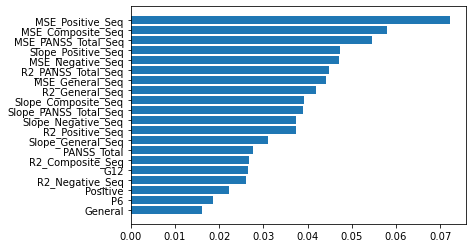

In [29]:
feats[indices]

Index(['MSE_Positive_Seq', 'MSE_Composite_Seq', 'MSE_PANSS_Total_Seq',
       'Slope_Positive_Seq', 'MSE_Negative_Seq', 'R2_PANSS_Total_Seq',
       'MSE_General_Seq', 'R2_General_Seq', 'Slope_Composite_Seq',
       'Slope_PANSS_Total_Seq', 'Slope_Negative_Seq', 'R2_Positive_Seq',
       'Slope_General_Seq', 'PANSS_Total', 'R2_Composite_Seq', 'G12',
       'R2_Negative_Seq', 'Positive', 'P6', 'General', 'Composite', 'P2',
       'Negative', 'P1', 'P7', 'P3', 'G9', 'P5', 'G8', 'G14', 'N5',
       'PANSS_Total_prev', 'G16', 'N1', 'G15', 'N3', 'P4', 'N6', 'G10', 'N2',
       'G2', 'G13', 'General_prev', 'G11', 'N4', 'G4', 'N7', 'G5', 'G6', 'G1',
       'G7', 'Positive_prev', 'Composite_prev', 'G3', 'Negative_prev'],
      dtype='object')

In [184]:
importances[indices]

array([1.40245771e-01, 8.55286337e-02, 7.76556365e-02, 6.91626013e-02,
       5.86770563e-02, 5.33912572e-02, 3.66308945e-02, 3.52056063e-02,
       3.30511493e-02, 3.27835483e-02, 2.94378285e-02, 2.94081348e-02,
       2.81941034e-02, 2.56393244e-02, 2.38387248e-02, 2.34411041e-02,
       2.26480360e-02, 2.25928440e-02, 2.17732033e-02, 2.14421431e-02,
       2.03253377e-02, 1.50518521e-02, 1.16694161e-02, 1.00156883e-02,
       9.44744764e-03, 8.24098051e-03, 5.85159284e-03, 5.66715860e-03,
       4.94859949e-03, 4.63695283e-03, 4.59421141e-03, 4.51221239e-03,
       3.37270363e-03, 2.19003545e-03, 1.91403649e-03, 1.88545904e-03,
       1.65101013e-03, 1.55285507e-03, 1.49817471e-03, 1.39949510e-03,
       1.35999088e-03, 1.04868642e-03, 9.82019688e-04, 9.47929659e-04,
       9.38222053e-04, 8.39931761e-04, 6.72872633e-04, 4.48341720e-04,
       4.17310468e-04, 4.08136319e-04, 2.56301594e-04, 2.09914274e-04,
       2.09295882e-04, 4.52469990e-05, 4.29795866e-05])

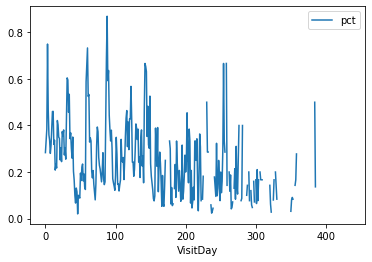

In [52]:
temp_d = df.pivot_table(index=['VisitDay'], columns=['BadRating'], values='PANSS_Total',aggfunc='count')
temp_d['pct'] = temp_d.loc[:, 1] / (temp_d.loc[:, 1] + temp_d.loc[:, 0])
temp_d.plot(y='pct')

In [70]:

    
def check_linearity(row, col_x, col_y):
    X = np.array(row[col_x]).reshape(-1, 1)
    y = row[col_y]
        
    lr = LinearRegression()
    _ = lr.fit(X, y)
    y_pred = lr.predict(X)
    row[f'R2_{col_y}'] = r2_score(y_pred, y) if row['nvisits'] > 2 else np.nan
    row[f'MSE_{col_y}'] = mean_squared_error(y_pred, y) if row['nvisits'] > 2 else np.nan
    row[f'Slope_{col_y}'] = lr.coef_[0] if row['nvisits'] > 2 else np.nan
    
    return row


#df.groupby('PatientID')[['Positive', 'Negative', 'General', 'Composite', 'PANSS_Total']].apply(list)
assess_history = pd.DataFrame()

assess_history['VisitDay_Seq'] = df.groupby('PatientID')['VisitDay'].apply(list)
assess_history['nvisits'] = assess_history['VisitDay_Seq'].apply(len)
assess_history['PANSS_Total_Seq'] = df.groupby('PatientID')['PANSS_Total'].apply(list)
assess_history = assess_history.apply(check_linearity, args=('VisitDay_Seq','PANSS_Total_Seq'), axis=1)
assess_history = assess_history[['R2_PANSS_Total_Seq','MSE_PANSS_Total_Seq','Slope_PANSS_Total_Seq']]
assess_history

VisitDay_Seq  nvisits  \
PatientID                                                               
10001                            [0, 11, 18, 25, 39, 53, 67]        7   
10002                                              [0, 7, 9]        3   
10003                                [0, 11, 18, 25, 39, 53]        6   
10004                        [0, 13, 20, 27, 42, 56, 69, 98]        8   
10005                    [0, 10, 16, 24, 38, 52, 64, 80, 93]        9   
...                                                      ...      ...   
40219                         [0, 7, 10, 14, 21, 35, 63, 83]        8   
40220      [0, 8, 11, 15, 22, 36, 64, 78, 92, 107, 113, 1...       17   
40221      [0, 14, 17, 21, 28, 42, 72, 84, 98, 113, 119, ...       17   
40222                      [0, 4, 7, 11, 19, 32, 60, 74, 88]        9   
40223                            [0, 14, 17, 21, 28, 42, 70]        7   

                                             PANSS_Total_Seq  \
PatientID                                                      
10001                         [107, 109, 91, 80, 77, 75, 72]   
10002                                           [85, 85, 94]   
10003                          [97, 128, 126, 119, 101, 111]   
10004                       [95, 96, 83, 77, 72, 71, 73, 65]   
10005                   [98, 97, 91, 87, 77, 70, 73, 66, 58]   
...                                                      ...   
40219                       [96, 96, 70, 62, 52, 51, 43, 43]   
40220      [94, 94, 93, 58, 54, 49, 49, 41, 41, 41, 41, 4...   
40221      [82, 82, 81, 76, 74, 72, 55, 63, 57, 56, 72, 8...   
40222                   [80, 72, 72, 70, 71, 60, 46, 48, 52]   
40223                           [83, 79, 79, 71, 74, 77, 72]   

           R2_PANSS_Total_Seq  MSE_PANSS_Total_Seq  Slope_PANSS_Total_Seq  
PatientID                                                                  
10001                0.733447            42.615099              -0.573070  
10002               -0.214876             9.873134               0.738806  
10003             -100.619724           137.205371              -0.066222  
10004                0.712755            25.382993              -0.309924  
10005                0.950752             8.448542              -0.427888  
...                       ...                  ...                    ...  
40219                0.411983           151.949443              -0.582969  
40220                0.350030           155.213212              -0.257263  
40221               -2.044431            77.144790              -0.090503  
40222                0.828842            19.586963              -0.343644  
40223               -0.302751             9.028698              -0.124943  

[2434 rows x 6 columns]

In [77]:
df

Study Country  PatientID  SiteID  RaterID    TxGroup  VisitDay  \
AssessmentID                                                                  
100679           A     USA      10001   20035    30076    Control         0   
101017           A     USA      10001   20035    30076    Control        11   
102177           A     USA      10001   20035    30076    Control        18   
101533           A     USA      10001   20035    30076    Control        25   
100930           A     USA      10001   20035    30076    Control        39   
...            ...     ...        ...     ...      ...        ...       ...   
400496           D   China      40223   80001   120013  Treatment        17   
402261           D   China      40223   80001   120013  Treatment        21   
400605           D   China      40223   80001   120013  Treatment        28   
402460           D   China      40223   80001   120013  Treatment        42   
401180           D   China      40223   80001   120013  Treatment        70   

              P1  P2  P3  ...  G14  G15  G16  PANSS_Total    LeadStatus  \
AssessmentID              ...                                             
100679         5   5   5  ...    3    3    5          107  Assign to CS   
101017         5   5   5  ...    3    3    5          109  Assign to CS   
102177         4   4   4  ...    2    3    4           91        Passed   
101533         3   3   3  ...    2    3    4           80       Flagged   
100930         3   3   4  ...    2    3    4           77       Flagged   
...           ..  ..  ..  ...  ...  ...  ...          ...           ...   
400496         4   3   4  ...    2    4    4           79       Flagged   
402261         4   3   4  ...    2    3    3           71       Flagged   
400605         4   3   4  ...    2    3    3           74       Flagged   
402460         4   3   4  ...    2    4    3           77       Flagged   
401180         4   3   3  ...    2    4    3           72       Flagged   

              Positive  Negative  General  Composite  BadRating  
AssessmentID                                                     
100679              30        24       53          6          1  
101017              30        25       54          5          1  
102177              23        24       44         -1          0  
101533              19        22       39         -3          1  
100930              19        21       37         -2          1  
...                ...       ...      ...        ...        ...  
400496              18        21       40         -3          1  
402261              18        18       35          0          1  
400605              19        19       36          0          1  
402460              19        20       38         -1          1  
401180              17        19       36         -2          1  

[20947 rows x 44 columns]

In [78]:
df = df.merge(assess_history.reset_index(), how='left', on='PatientID')
df

Study Country  PatientID  SiteID  RaterID    TxGroup  VisitDay  P1  P2  \
0         A     USA      10001   20035    30076    Control         0   5   5   
1         A     USA      10001   20035    30076    Control        11   5   5   
2         A     USA      10001   20035    30076    Control        18   4   4   
3         A     USA      10001   20035    30076    Control        25   3   3   
4         A     USA      10001   20035    30076    Control        39   3   3   
...     ...     ...        ...     ...      ...        ...       ...  ..  ..   
20942     D   China      40223   80001   120013  Treatment        17   4   3   
20943     D   China      40223   80001   120013  Treatment        21   4   3   
20944     D   China      40223   80001   120013  Treatment        28   4   3   
20945     D   China      40223   80001   120013  Treatment        42   4   3   
20946     D   China      40223   80001   120013  Treatment        70   4   3   

       P3  ...  PANSS_Total    LeadStatus  Positive  Negative  General  \
0       5  ...          107  Assign to CS        30        24       53   
1       5  ...          109  Assign to CS        30        25       54   
2       4  ...           91        Passed        23        24       44   
3       3  ...           80       Flagged        19        22       39   
4       4  ...           77       Flagged        19        21       37   
...    ..  ...          ...           ...       ...       ...      ...   
20942   4  ...           79       Flagged        18        21       40   
20943   4  ...           71       Flagged        18        18       35   
20944   4  ...           74       Flagged        19        19       36   
20945   4  ...           77       Flagged        19        20       38   
20946   3  ...           72       Flagged        17        19       36   

       Composite  BadRating  R2_PANSS_Total_Seq  MSE_PANSS_Total_Seq  \
0              6          1            0.733447            42.615099   
1              5          1            0.733447            42.615099   
2             -1          0            0.733447            42.615099   
3             -3          1            0.733447            42.615099   
4             -2          1            0.733447            42.615099   
...          ...        ...                 ...                  ...   
20942         -3          1           -0.302751             9.028698   
20943          0          1           -0.302751             9.028698   
20944          0          1           -0.302751             9.028698   
20945         -1          1           -0.302751             9.028698   
20946         -2          1           -0.302751             9.028698   

       Slope_PANSS_Total_Seq  
0                  -0.573070  
1                  -0.573070  
2                  -0.573070  
3                  -0.573070  
4                  -0.573070  
...                      ...  
20942              -0.124943  
20943              -0.124943  
20944              -0.124943  
20945              -0.124943  
20946              -0.124943  

[20947 rows x 47 columns]

In [40]:
df[df.LeadStatus != 'Passed'].PatientID.unique()

array([10001, 10003, 10004, ..., 40221, 40222, 40223], dtype=int64)

In [32]:
df[df.PatientID == 10001]

Study Country  PatientID  SiteID  RaterID  TxGroup  VisitDay  P1  \
AssessmentID                                                                    
100679           A     USA      10001   20035    30076  Control         0   5   
101017           A     USA      10001   20035    30076  Control        11   5   
102177           A     USA      10001   20035    30076  Control        18   4   
101533           A     USA      10001   20035    30076  Control        25   3   
100930           A     USA      10001   20035    30076  Control        39   3   
100471           A     USA      10001   20035    30076  Control        53   3   
102347           A     USA      10001   20035    30076  Control        67   4   

              P2  P3  ...  G13  G14  G15  G16  PANSS_Total    LeadStatus  \
AssessmentID          ...                                                  
100679         5   5  ...    3    3    3    5          107  Assign to CS   
101017         5   5  ...    3    3    3    5          109  Assign to CS   
102177         4   4  ...    3    2    3    4           91        Passed   
101533         3   3  ...    3    2    3    4           80       Flagged   
100930         3   4  ...    3    2    3    4           77       Flagged   
100471         3   4  ...    3    2    3    4           75       Flagged   
102347         2   4  ...    3    2    3    4           72       Flagged   

              Positive  Negative  General  Composite  
AssessmentID                                          
100679              30        24       53          6  
101017              30        25       54          5  
102177              23        24       44         -1  
101533              19        22       39         -3  
100930              19        21       37         -2  
100471              18        20       37         -2  
102347              17        19       36         -2  

[7 rows x 43 columns]

In [38]:
df[df.PatientID == 40223]

Study Country  PatientID  SiteID  RaterID    TxGroup  VisitDay  \
AssessmentID                                                                  
401434           D   China      40223   80001   120013  Treatment         0   
402855           D   China      40223   80001   120013  Treatment        14   
400496           D   China      40223   80001   120013  Treatment        17   
402261           D   China      40223   80001   120013  Treatment        21   
400605           D   China      40223   80001   120013  Treatment        28   
402460           D   China      40223   80001   120013  Treatment        42   
401180           D   China      40223   80001   120013  Treatment        70   

              P1  P2  P3  ...  G13  G14  G15  G16  PANSS_Total  LeadStatus  \
AssessmentID              ...                                                
401434         4   3   4  ...    2    2    4    4           83     Flagged   
402855         4   3   4  ...    2    2    4    4           79     Flagged   
400496         4   3   4  ...    2    2    4    4           79     Flagged   
402261         4   3   4  ...    2    2    3    3           71     Flagged   
400605         4   3   4  ...    2    2    3    3           74     Flagged   
402460         4   3   4  ...    2    2    4    3           77     Flagged   
401180         4   3   3  ...    2    2    4    3           72     Flagged   

              Positive  Negative  General  Composite  
AssessmentID                                          
401434              21        21       41          0  
402855              19        20       40         -1  
400496              18        21       40         -3  
402261              18        18       35          0  
400605              19        19       36          0  
402460              19        20       38         -1  
401180              17        19       36         -2  

[7 rows x 43 columns]

In [41]:
df[df.PatientID == 10003]

Study Country  PatientID  SiteID  RaterID    TxGroup  VisitDay  \
AssessmentID                                                                  
101799           A     USA      10003   20031    30058  Treatment         0   
100330           A     USA      10003   20031    30058  Treatment        11   
101749           A     USA      10003   20031    30058  Treatment        18   
101301           A     USA      10003   20031    30058  Treatment        25   
101615           A     USA      10003   20031    30058  Treatment        39   
101974           A     USA      10003   20031    30058  Treatment        53   

              P1  P2  P3  ...  G13  G14  G15  G16  PANSS_Total  LeadStatus  \
AssessmentID              ...                                                
101799         5   5   5  ...    3    3    3    4           97     Flagged   
100330         6   5   6  ...    4    4    5    5          128     Flagged   
101749         6   5   6  ...    4    3    5    5          126     Flagged   
101301         5   5   5  ...    4    4    4    5          119     Flagged   
101615         4   4   5  ...    3    4    4    4          101     Flagged   
101974         5   5   5  ...    4    4    5    3          111     Flagged   

              Positive  Negative  General  Composite  
AssessmentID                                          
101799              29        23       45          6  
100330              34        31       63          3  
101749              34        31       61          3  
101301              32        29       58          3  
101615              27        25       49          2  
101974              33        26       52          7  

[6 rows x 43 columns]

In [49]:
df[df.PatientID == 10004]

Study Country  PatientID  SiteID  RaterID  TxGroup  VisitDay  P1  \
AssessmentID                                                                    
101826           A     USA      10004   20006    30013  Control         0   5   
100975           A     USA      10004   20006    30013  Control        13   5   
100729           A     USA      10004   20006    30013  Control        20   4   
102374           A     USA      10004   20006    30013  Control        27   3   
101129           A     USA      10004   20006    30013  Control        42   3   
100037           A     USA      10004   20006    30013  Control        56   3   
100485           A     USA      10004   20006    30013  Control        69   3   
100878           A     USA      10004   20006    30013  Control        98   3   

              P2  P3  ...  G13  G14  G15  G16  PANSS_Total    LeadStatus  \
AssessmentID          ...                                                  
101826         5   5  ...    3    1    4    4           95        Passed   
100975         5   5  ...    3    1    4    4           96        Passed   
100729         3   4  ...    3    1    3    3           83       Flagged   
102374         3   3  ...    3    1    3    3           77       Flagged   
101129         2   3  ...    3    1    3    2           72        Passed   
100037         2   3  ...    3    1    3    2           71        Passed   
100485         2   5  ...    3    1    3    2           73       Flagged   
100878         2   4  ...    3    1    2    3           65  Assign to CS   

              Positive  Negative  General  Composite  
AssessmentID                                          
101826              26        27       42         -1  
100975              26        27       43         -1  
100729              21        24       38         -3  
102374              20        20       37          0  
101129              16        22       34         -6  
100037              16        22       33         -6  
100485              18        22       33         -4  
100878              17        20       28         -3  

[8 rows x 43 columns]

In [50]:

df[df.PatientID == 40221]

Study Country  PatientID  SiteID  RaterID    TxGroup  VisitDay  \
AssessmentID                                                                  
401715           D   China      40221   80001   120048  Treatment         0   
402516           D   China      40221   80001   120048  Treatment        14   
400475           D   China      40221   80001   120048  Treatment        17   
402727           D   China      40221   80001   120048  Treatment        21   
401499           D   China      40221   80001   120048  Treatment        28   
401427           D   China      40221   80001   120048  Treatment        42   
400433           D   China      40221   80001   120048  Treatment        72   
402394           D   China      40221   80001   120048  Treatment        84   
401543           D   China      40221   80001   120048  Treatment        98   
402523           D   China      40221   80001   120048  Treatment       113   
400943           D   China      40221   80001   120048  Treatment       119   
400096           D   China      40221   80001   120048  Treatment       121   
400399           D   China      40221   80001   120048  Treatment       121   
402833           D   China      40221   80001   120048  Treatment       121   
402576           D   China      40221   80001   120048  Treatment       128   
400272           D   China      40221   80001   120048  Treatment       149   
402025           D   China      40221   80001   120048  Treatment       205   

              P1  P2  P3  ...  G13  G14  G15  G16  PANSS_Total    LeadStatus  \
AssessmentID              ...                                                  
401715         3   4   2  ...    3    1    6    1           82  Assign to CS   
402516         3   4   2  ...    3    1    6    4           82  Assign to CS   
400475         3   4   2  ...    3    1    5    4           81       Flagged   
402727         2   3   2  ...    3    1    4    4           76  Assign to CS   
401499         2   2   1  ...    3    1    4    4           74       Flagged   
401427         2   2   1  ...    3    1    4    4           72  Assign to CS   
400433         2   1   1  ...    2    1    3    3           55       Flagged   
402394         2   2   2  ...    2    1    3    3           63       Flagged   
401543         2   2   2  ...    2    1    2    3           57       Flagged   
402523         2   2   2  ...    2    1    2    3           56       Flagged   
400943         2   2   2  ...    3    2    4    3           72       Flagged   
400096         2   3   2  ...    3    3    5    4           81       Flagged   
400399         2   3   2  ...    3    3    5    4           81       Flagged   
402833         2   3   2  ...    3    3    5    4           81       Flagged   
402576         2   2   2  ...    2    2    3    3           65       Flagged   
400272         2   2   2  ...    3    2    3    3           65       Flagged   
402025         2   1   1  ...    2    2    3    2           55       Flagged   

              Positive  Negative  General  Composite  
AssessmentID                                          
401715              20        24       38         -4  
402516              18        23       41         -5  
400475              18        23       40         -5  
402727              16        23       37         -7  
401499              13        24       37        -11  
401427              12        25       35        -13  
400433              10        17       28         -7  
402394              13        18       32         -5  
401543              13        16       28         -3  
402523              13        16       27         -3  
400943              12        20       40         -8  
400096              13        20       48         -7  
400399              13        20       48         -7  
402833              13        20       48         -7  
402576              12        19       34         -7  
400272              13        18       34         -5  


In [51]:

df[df.PatientID == 40222]

Study Country  PatientID  SiteID  RaterID  TxGroup  VisitDay  P1  \
AssessmentID                                                                    
401303           D   China      40222   80001   120050  Control         0   6   
400791           D   China      40222   80001   120050  Control         4   6   
402656           D   China      40222   80001   120050  Control         7   6   
401219           D   China      40222   80001   120050  Control        11   6   
402047           D   China      40222   80001   120050  Control        19   5   
401911           D   China      40222   80001   120050  Control        32   4   
402457           D   China      40222   80001   120050  Control        60   4   
401058           D   China      40222   80001   120050  Control        74   3   
400879           D   China      40222   80001   120050  Control        88   3   

              P2  P3  ...  G13  G14  G15  G16  PANSS_Total    LeadStatus  \
AssessmentID          ...                                                  
401303         3   5  ...    2    4    2    4           80        Passed   
400791         2   4  ...    2    2    2    3           72        Passed   
402656         2   4  ...    1    2    2    3           72        Passed   
401219         2   2  ...    1    3    2    3           70        Passed   
402047         2   2  ...    2    3    2    2           71        Passed   
401911         1   1  ...    2    2    1    2           60        Passed   
402457         1   1  ...    1    1    1    2           46        Passed   
401058         1   1  ...    1    1    1    3           48        Passed   
400879         1   1  ...    2    1    1    3           52  Assign to CS   

              Positive  Negative  General  Composite  
AssessmentID                                          
401303              24        15       41          9  
400791              22        18       32          4  
402656              22        18       32          4  
401219              21        15       34          6  
402047              19        15       37          4  
401911              16        14       30          2  
402457              12        11       23          1  
401058              11        14       23         -3  
400879              12        13       27         -1  

[9 rows x 43 columns]

In [232]:
def impute_with_lr(df):
    def predict_row(row):

        X = row.iloc[:17].index.values.reshape(-1,1)
        y = row.iloc[:17].values

        lr = LinearRegression()
        _ = lr.fit(X, y)
        row[18] = lr.predict([[18]])
        row.r2 = r2_score(lr.predict(X), y)
        return row

    panss_by_time = df.pivot_table(index='PatientID', columns='Week', values='PANSS_Total', aggfunc='mean')
    panss_by_time = panss_by_time.interpolate(method='linear', axis=1).iloc[:, :17]
    panss_by_time.loc[:,18] = 0
    panss_by_time['r2'] = 0
    panss_by_time = panss_by_time.apply(predict_row, axis=1)
    return panss_by_time

def forecast_predict_1(df, model_forcast):
    df = raw_df[raw_df.Study == 'E'].copy()
    df['Week'] = df.VisitDay.apply(lambda x: x // 7 + 1)
    df = df[['PatientID', 'Week','PANSS_Total']]
    panss_by_time = df.pivot_table(index='PatientID', columns='Week', values='PANSS_Total', aggfunc='mean')

    visit_count = panss_by_time.notnull().sum(axis=1)
    nvisits = 3
    pat_ids_more_visits = visit_count[visit_count >= nvisits].index
    pat_ids_less_visits = visit_count[visit_count < nvisits].index

    pats_more_visits = panss_by_time.loc[pat_ids_more_visits]
    pats_more_visits = pats_more_visits.interpolate(method='linear', axis=1).loc[:, :17]
    # pats_more_visits = pats_more_visits.interpolate(method='linear', axis=1, fill_value='extrapolate')
    pats_more_visits.loc[:, 18] = model_forcast['ridge'].predict(pats_more_visits)

    pats_less_visits = panss_by_time.loc[pat_ids_less_visits].loc[:, :17]
    pats_less_visits.loc[:, 18] = model_forcast['knn'].predict(pats_less_visits.loc[:, [1]])

    predicted_panss = pats_less_visits.append(pats_more_visits)
    predicted_panss = predicted_panss.reset_index()[['PatientID', 18]].rename(columns={18: 'PANSS_Total'})
    predicted_panss = predicted_panss.sort_values('PatientID')
    predicted_panss.to_csv('forecasting.csv',index=False)
    return predicted_panss

print('######### Forecasting #########')

df = data_prepare_forecast(raw_df, nvisits=3, start_visit_day_threshold=6,target_visit_day_threshold=18*7)
df_linear = impute_with_lr(df)
print('Data processed.')

compare_interpolation(df, df_linear, df_quad, show_fig=False, save_fig_as='Interpolation.jpg')
print('Missing values are interpolated in two ways: (1) Linear Spline; (2) Quadratic Spline')
print('Figure saved on disk.')
        
scores_linear = feature_model_selection_forecast(df_linear)
print('\nRegression Results for Linear-Spline Interpolation:')
print(scores_linear.round(4))

model_forcast = best_model_forcast(df_linear)
print('Best model Trained: (1) Quadratic-Spline Interpolation + Ridge Regression; (2) KNN Regression')

forecast_predict(df, model_forcast)

######### Forecasting #########
Data processed.
Missing values are interpolated in two ways: (1) Linear Spline; (2) Quadratic Spline
Figure saved on disk.

Regression Results for Linear-Spline Interpolation:
        test_r2  train_r2  test_mse  train_mse
linear      1.0       1.0    0.0000     0.0000
lasso       1.0       1.0    0.0034     0.0031
ridge       1.0       1.0    0.0000     0.0000
Best model Trained: (1) Quadratic-Spline Interpolation + Ridge Regression; (2) KNN Regression


In [166]:
def forecast_predict(df, model_forcast):
    df = raw_df[raw_df.Study == 'E'].copy()
    df['Week'] = df.VisitDay.apply(lambda x: x // 7 + 1)
    df = df[['PatientID', 'Week','PANSS_Total']]
    panss_by_time = df.pivot_table(index='PatientID', columns='Week', values='PANSS_Total', aggfunc='mean')

    visit_count = panss_by_time.notnull().sum(axis=1)
    nvisits = 3
    pat_ids_more_visits = visit_count[visit_count >= nvisits].index
    pat_ids_less_visits = visit_count[visit_count < nvisits].index

    pats_more_visits = panss_by_time.loc[pat_ids_more_visits]
    pats_more_visits = pats_more_visits.interpolate(method='quadratic', axis=1).loc[:, :17]
    pats_more_visits = pats_more_visits.interpolate(method='linear', axis=1, fill_value='extrapolate')
    pats_more_visits.loc[:, 18] = model_forcast['ridge'].predict(pats_more_visits)

    pats_less_visits = panss_by_time.loc[pat_ids_less_visits].loc[:, :17]
    pats_less_visits.loc[:, 18] = model_forcast['knn'].predict(pats_less_visits.loc[:, [1]])

    predicted_panss = pats_less_visits.append(pats_more_visits)
    predicted_panss = predicted_panss.reset_index()[['PatientID', 18]].rename(columns={18: 'PANSS_Total'})
    predicted_panss = predicted_panss.sort_values('PatientID')
    predicted_panss.to_csv('forecasting.csv',index=False)
    return predicted_panss

In [167]:
predicted_panss

Week  PatientID  PANSS_Total
0         50001    57.073815
145       50002    75.539227
146       50003    79.833809
147       50004    62.938621
148       50005    74.519365
..          ...          ...
511       50509    61.084236
142       50510    59.362430
143       50511    47.261573
512       50512    60.087474
144       50513    46.335416

[513 rows x 2 columns]

In [114]:
pats_more_visits[pats_more_visits.isnull().apply(lambda row: any(row), axis=1)].head()

Week         1          2           3           4          5          6   \
PatientID                                                                  
50043      59.0  57.842949   56.000000   53.471154  51.000000  49.330128   
50047      81.0  80.395833   79.833333   79.312500  78.833333  78.395833   
50066      89.0  88.242424   87.363636   86.363636  85.242424  84.000000   
50074      68.0  68.750000   69.333333   69.750000  70.000000  70.083333   
50083      85.0  95.000000  100.792793  102.378378  99.756757  95.411411   

Week              7          8          9          10         11         12  \
PatientID                                                                     
50043      48.461538  48.394231  49.128205  50.663462  53.000000        NaN   
50047      78.000000  77.645833  77.333333  77.062500  76.833333  76.645833   
50066      82.636364  81.151515  79.545455  77.818182  75.969697  74.000000   
50074      70.000000  69.750000  69.333333  68.750000  68.000000  67.083333   
50083      91.825826  89.000000  86.933934  85.627628  85.081081  85.294294   

Week              13    14  15  16  17  
PatientID                               
50043            NaN   NaN NaN NaN NaN  
50047      76.500000   NaN NaN NaN NaN  
50066            NaN   NaN NaN NaN NaN  
50074      66.000000   NaN NaN NaN NaN  
50083      86.267267  88.0 NaN NaN NaN

In [116]:
pats_more_visits[pats_more_visits.isnull().apply(lambda row: any(row), axis=1)].interpolate(method='linear', axis=1, fill_value='extrapolate').head()

Week         1          2           3           4          5          6   \
PatientID                                                                  
50043      59.0  57.842949   56.000000   53.471154  51.000000  49.330128   
50047      81.0  80.395833   79.833333   79.312500  78.833333  78.395833   
50066      89.0  88.242424   87.363636   86.363636  85.242424  84.000000   
50074      68.0  68.750000   69.333333   69.750000  70.000000  70.083333   
50083      85.0  95.000000  100.792793  102.378378  99.756757  95.411411   

Week              7          8          9          10         11         12  \
PatientID                                                                     
50043      48.461538  48.394231  49.128205  50.663462  53.000000  53.000000   
50047      78.000000  77.645833  77.333333  77.062500  76.833333  76.645833   
50066      82.636364  81.151515  79.545455  77.818182  75.969697  74.000000   
50074      70.000000  69.750000  69.333333  68.750000  68.000000  67.083333   
50083      91.825826  89.000000  86.933934  85.627628  85.081081  85.294294   

Week              13    14    15    16    17  
PatientID                                     
50043      53.000000  53.0  53.0  53.0  53.0  
50047      76.500000  76.5  76.5  76.5  76.5  
50066      74.000000  74.0  74.0  74.0  74.0  
50074      66.000000  66.0  66.0  66.0  66.0  
50083      86.267267  88.0  88.0  88.0  88.0

In [45]:
ss = panss_by_time.notnull().sum(axis=1).sort_values()
panss_by_time.loc[ss[ss>1].index]

Week         1     2     3     4     5     6     7   8   9   10  ...  29  30  \
PatientID                                                        ...           
50254      54.0   NaN   NaN   NaN   NaN   NaN  52.0 NaN NaN NaN  ... NaN NaN   
50392      48.0   NaN   NaN   NaN   NaN  52.0   NaN NaN NaN NaN  ... NaN NaN   
50319      90.0   NaN   NaN   NaN   NaN   NaN  85.0 NaN NaN NaN  ... NaN NaN   
50483      47.0   NaN   NaN   NaN   NaN  43.0   NaN NaN NaN NaN  ... NaN NaN   
50323      77.0   NaN   NaN   NaN   NaN   NaN   NaN NaN NaN NaN  ... NaN NaN   
...         ...   ...   ...   ...   ...   ...   ...  ..  ..  ..  ...  ..  ..   
50418      56.0   NaN   NaN   NaN   NaN   NaN   NaN NaN NaN NaN  ... NaN NaN   
50305      62.0   NaN  67.0   NaN  66.0   NaN   NaN NaN NaN NaN  ... NaN NaN   
50242      70.0  68.0   NaN   NaN  64.0   NaN   NaN NaN NaN NaN  ... NaN NaN   
50460      82.0   NaN  83.0   NaN  82.0   NaN   NaN NaN NaN NaN  ... NaN NaN   
50131      83.0   NaN   NaN  85.0   NaN  83.0   NaN NaN NaN NaN  ... NaN NaN   

Week       35  41    43    47    53    59  65    66  
PatientID                                            
50254     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50392     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50319     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50483     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50323     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
...        ..  ..   ...   ...   ...   ...  ..   ...  
50418     NaN NaN  53.0  62.0  56.0  64.0 NaN  64.0  
50305     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50242     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50460     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  
50131     NaN NaN   NaN   NaN   NaN   NaN NaN   NaN  

[421 rows x 38 columns]

In [41]:
ss

PatientID
50001    1
50093    1
50258    1
50259    1
50265    1
        ..
50418    6
50305    6
50242    6
50460    6
50131    6
Length: 513, dtype: int64

In [347]:
X = df_cubic.iloc[:, :17]
y = df_cubic.iloc[:, 17]
cv_result_lr = cross_validate(
    LinearRegression(), X, y, cv=5,           
    scoring=('r2', 'neg_mean_squared_error'),              
    return_train_score=True)
cv_result_lasso = cross_validate(
    Lasso(alpha=0.1,max_iter=8000), X, y, cv=5,           
    scoring=('r2', 'neg_mean_squared_error'),              
    return_train_score=True)
cv_result_ridge = cross_validate(
    Ridge(alpha=1.0), X, y, cv=5,           
    scoring=('r2', 'neg_mean_squared_error'),              
    return_train_score=True)

print('Linear: ')
mse_train = -cv_result_lr['train_neg_mean_squared_error'].mean()
mse_test = -cv_result_lr['test_neg_mean_squared_error'].mean()
r2_train = cv_result_lr['train_r2'].mean()
r2_test = cv_result_lr['test_r2'].mean()
print(f'Train MSE: {mse_train:.2f}; Test MSE: {mse_test:.2f}')
print(f'Train R2: {r2_train:.4f}; Test R2: {r2_test:.4f}')

print('Lasso: ')
mse_train = -cv_result_lasso['train_neg_mean_squared_error'].mean()
mse_test = -cv_result_lasso['test_neg_mean_squared_error'].mean()
r2_train = cv_result_lasso['train_r2'].mean()
r2_test = cv_result_lasso['test_r2'].mean()
print(f'Train MSE: {mse_train:.2f}; Test MSE: {mse_test:.2f}')
print(f'Train R2: {r2_train:.4f}; Test R2: {r2_test:.4f}')

print('Ridge: ')
mse_train = -cv_result_ridge['train_neg_mean_squared_error'].mean()
mse_test = -cv_result_ridge['test_neg_mean_squared_error'].mean()
r2_train = cv_result_ridge['train_r2'].mean()
r2_test = cv_result_ridge['test_r2'].mean()
print(f'Train MSE: {mse_train:.2f}; Test MSE: {mse_test:.2f}')
print(f'Train R2: {r2_train:.4f}; Test R2: {r2_test:.4f}')

Linear: 
Train MSE: 1.51; Test MSE: 2.55
Train R2: 0.9945; Test R2: 0.9810
Lasso: 
Train MSE: 1.83; Test MSE: 2.63
Train R2: 0.9933; Test R2: 0.9812
Ridge: 
Train MSE: 1.56; Test MSE: 2.31
Train R2: 0.9943; Test R2: 0.9834


In [348]:
X = df_linear.iloc[:, :17]
y = df_linear.iloc[:, 17]
cv_result_lr = cross_validate(
    LinearRegression(), X, y, cv=5,           
    scoring=('r2', 'neg_mean_squared_error'),              
    return_train_score=True)
cv_result_lasso = cross_validate(
    Lasso(alpha=0.1,max_iter=8000), X, y, cv=5,           
    scoring=('r2', 'neg_mean_squared_error'),              
    return_train_score=True)
cv_result_ridge = cross_validate(
    Ridge(alpha=1.0), X, y, cv=5,           
    scoring=('r2', 'neg_mean_squared_error'),              
    return_train_score=True)

print('Linear: ')
mse_train = -cv_result_lr['train_neg_mean_squared_error'].mean()
mse_test = -cv_result_lr['test_neg_mean_squared_error'].mean()
r2_train = cv_result_lr['train_r2'].mean()
r2_test = cv_result_lr['test_r2'].mean()
print(f'Train MSE: {mse_train:.2f}; Test MSE: {mse_test:.2f}')
print(f'Train R2: {r2_train:.4f}; Test R2: {r2_test:.4f}')

print('Lasso: ')
mse_train = -cv_result_lasso['train_neg_mean_squared_error'].mean()
mse_test = -cv_result_lasso['test_neg_mean_squared_error'].mean()
r2_train = cv_result_lasso['train_r2'].mean()
r2_test = cv_result_lasso['test_r2'].mean()
print(f'Train MSE: {mse_train:.2f}; Test MSE: {mse_test:.2f}')
print(f'Train R2: {r2_train:.4f}; Test R2: {r2_test:.4f}')

print('Ridge: ')
mse_train = -cv_result_ridge['train_neg_mean_squared_error'].mean()
mse_test = -cv_result_ridge['test_neg_mean_squared_error'].mean()
r2_train = cv_result_ridge['train_r2'].mean()
r2_test = cv_result_ridge['test_r2'].mean()
print(f'Train MSE: {mse_train:.2f}; Test MSE: {mse_test:.2f}')
print(f'Train R2: {r2_train:.4f}; Test R2: {r2_test:.4f}')

Linear: 
Train MSE: 4.16; Test MSE: 4.46
Train R2: 0.9612; Test R2: 0.9514
Lasso: 
Train MSE: 4.21; Test MSE: 4.36
Train R2: 0.9607; Test R2: 0.9525
Ridge: 
Train MSE: 4.16; Test MSE: 4.46
Train R2: 0.9612; Test R2: 0.9514


In [318]:
X = df_cubic.iloc[:, :17]
y = df_cubic.iloc[:, 17]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


In [319]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('train MSE:', mean_squared_error(y_train, lr.predict(X_train)))
print('train R2:', r2_score(y_train, lr.predict(X_train)))
print('')
print('test MSE:', mean_squared_error(y_test, lr.predict(X_test)))
print('test R2:', r2_score(y_test, lr.predict(X_test)))

test_df = X_test.join(y_test)
test_df['y_pred'] = lr.predict(X_test)
test_df

train MSE: 1.5337008710010287
train R2: 0.9972042051634705

test MSE: 2.5446988002985376
test R2: 0.9828470313618851


1           2           3           4           5           6  \
PatientID                                                                      
30804       84.0   86.000000   71.000000   63.061320   62.100997   62.000000   
30557       89.0   91.051960   91.407232   90.422744   88.455424   85.862200   
30429       75.0   74.186563   72.000000   69.063437   66.000000   63.322073   
30413       81.0   80.222639   77.000000   72.097580   66.280874   60.315378   
40048       73.5   62.000000   60.000000   57.979357   54.608828   50.607021   
...          ...         ...         ...         ...         ...         ...   
31318       83.0   82.000000   70.000000   59.262905   51.841942   47.237914   
30018      116.5  118.000000  117.829709  116.466846  114.389128  112.074274   
30644       93.0   89.300988   86.000000   82.948518   79.998024   77.000000   
20137       80.0   76.500000   78.000000   75.197051   70.000000   66.222101   
30546       84.0   81.000000   77.329595   73.559190   70.259190   68.000000   

                    7           8           9          10          11  \
PatientID                                                               
30804       58.017287   50.923776   42.868378   36.000000   32.013589   
30557       83.000000   80.225752   77.896384   76.368824   76.000000   
30429       61.099069   59.289659   57.852514   56.746305   55.929702   
30413       54.966588   51.000000   48.942585   48.367215   48.608238   
40048       46.692542   43.583999   42.000000   42.624144   46.000000   
...               ...         ...         ...         ...         ...   
31318       44.951627   44.483888   45.335500   47.007269   49.000000   
30018      110.000000  108.607068  108.188410  109.000000  110.878047   
30644       73.877137   70.836965   68.158225   66.119656   65.000000   
20137       64.082439   62.901558   62.000000   60.830684   59.376032   
30546       67.089846   66.788240   66.092514   64.000000   60.029770   

                   12          13          14         15         16  \
PatientID                                                             
30804       30.788238   31.749074   34.321228  37.929827  42.000000   
30557       76.846049   77.759944   77.293867  74.000000  68.000000   
30429       55.361377   55.000000   54.813714  54.808547  55.000000   
30413       49.000000   49.021203   48.727959  48.320736  48.000000   
40048       52.221683   59.725520   66.533390  70.667174  70.148751   
...               ...         ...         ...        ...        ...   
31318       50.842676   52.176989   52.672807  52.000000  50.000000   
30018      111.979693  110.042316  102.803293  88.000000  69.000000   
30644       64.956351   65.659222   66.657482  67.500000  67.840487   
20137       57.750840   56.069906   54.448027  53.000000  51.813291   
30546       55.787850   53.402005   55.000000  60.000000  59.968022   

                  17         18     y_pred  
PatientID                                   
30804      45.948312  49.157065  47.942420  
30557      64.183663  62.971229  63.798220  
30429      55.000000  53.390871  54.807093  
30413      48.000000  48.581791  47.908752  
40048      63.000000  49.000000  55.602063  
...              ...        ...        ...  
31318      47.200497  44.300746  45.032337  
30018      64.367436  69.000000  71.445577  
30644      67.752030  67.412558  67.435630  
20137      50.866040  50.109057  50.232409  
30546      55.705472  51.000000  51.398986  

[280 rows x 19 columns]

In [320]:
lr.coef_

array([-2.42021483e-03, -2.45701741e-02,  2.06143310e-02, -1.03595982e-03,
       -1.65948213e-02,  5.83526216e-02, -2.59865852e-01,  8.09892096e-01,
       -9.10755236e-01, -9.67737962e-01,  4.82500504e+00, -8.05690096e+00,
        7.71796993e+00, -4.74835661e+00,  2.77417478e+00, -2.55531316e+00,
        2.33252263e+00])

In [329]:
lasso = Lasso(alpha=0.1,max_iter=8000)
lasso.fit(X_train, y_train)
print('train MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('train R2:', r2_score(y_train, lasso.predict(X_train)))
print('')
print('test MSE:', mean_squared_error(y_test, lasso.predict(X_test)))
print('test R2:', r2_score(y_test, lasso.predict(X_test)))

test_df = X_test.join(y_test)
test_df['y_pred'] = lasso.predict(X_test)
test_df

train MSE: 1.8693226300793868
train R2: 0.9965923977381766

test MSE: 1.8879422977220486
test R2: 0.9872740086097428


1           2           3           4           5           6  \
PatientID                                                                      
30804       84.0   86.000000   71.000000   63.061320   62.100997   62.000000   
30557       89.0   91.051960   91.407232   90.422744   88.455424   85.862200   
30429       75.0   74.186563   72.000000   69.063437   66.000000   63.322073   
30413       81.0   80.222639   77.000000   72.097580   66.280874   60.315378   
40048       73.5   62.000000   60.000000   57.979357   54.608828   50.607021   
...          ...         ...         ...         ...         ...         ...   
31318       83.0   82.000000   70.000000   59.262905   51.841942   47.237914   
30018      116.5  118.000000  117.829709  116.466846  114.389128  112.074274   
30644       93.0   89.300988   86.000000   82.948518   79.998024   77.000000   
20137       80.0   76.500000   78.000000   75.197051   70.000000   66.222101   
30546       84.0   81.000000   77.329595   73.559190   70.259190   68.000000   

                    7           8           9          10          11  \
PatientID                                                               
30804       58.017287   50.923776   42.868378   36.000000   32.013589   
30557       83.000000   80.225752   77.896384   76.368824   76.000000   
30429       61.099069   59.289659   57.852514   56.746305   55.929702   
30413       54.966588   51.000000   48.942585   48.367215   48.608238   
40048       46.692542   43.583999   42.000000   42.624144   46.000000   
...               ...         ...         ...         ...         ...   
31318       44.951627   44.483888   45.335500   47.007269   49.000000   
30018      110.000000  108.607068  108.188410  109.000000  110.878047   
30644       73.877137   70.836965   68.158225   66.119656   65.000000   
20137       64.082439   62.901558   62.000000   60.830684   59.376032   
30546       67.089846   66.788240   66.092514   64.000000   60.029770   

                   12          13          14         15         16  \
PatientID                                                             
30804       30.788238   31.749074   34.321228  37.929827  42.000000   
30557       76.846049   77.759944   77.293867  74.000000  68.000000   
30429       55.361377   55.000000   54.813714  54.808547  55.000000   
30413       49.000000   49.021203   48.727959  48.320736  48.000000   
40048       52.221683   59.725520   66.533390  70.667174  70.148751   
...               ...         ...         ...        ...        ...   
31318       50.842676   52.176989   52.672807  52.000000  50.000000   
30018      111.979693  110.042316  102.803293  88.000000  69.000000   
30644       64.956351   65.659222   66.657482  67.500000  67.840487   
20137       57.750840   56.069906   54.448027  53.000000  51.813291   
30546       55.787850   53.402005   55.000000  60.000000  59.968022   

                  17         18     y_pred  
PatientID                                   
30804      45.948312  49.157065  47.534563  
30557      64.183663  62.971229  63.421002  
30429      55.000000  53.390871  54.723055  
30413      48.000000  48.581791  47.948715  
40048      63.000000  49.000000  56.415660  
...              ...        ...        ...  
31318      47.200497  44.300746  45.184598  
30018      64.367436  69.000000  69.657825  
30644      67.752030  67.412558  67.340227  
20137      50.866040  50.109057  50.241756  
30546      55.705472  51.000000  50.441874  

[280 rows x 19 columns]

In [158]:
lasso.coef_

array([ 0.        ,  0.        , -0.        ,  0.        ,  0.00496838,
        0.00631321,  0.        , -0.        , -0.        , -0.00498596,
       -0.00122734, -0.        , -0.        , -0.        , -0.014747  ,
       -0.06741453,  1.04914435])

In [332]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
print('train MSE:', mean_squared_error(y_train, ridge.predict(X_train)))
print('train R2:', r2_score(y_train, ridge.predict(X_train)))
print('')
print('test MSE:', mean_squared_error(y_test, ridge.predict(X_test)))
print('test R2:', r2_score(y_test, ridge.predict(X_test)))

test_df = X_test.join(y_test)
test_df['y_pred'] = ridge.predict(X_test)
test_df


train MSE: 1.6014216108032742
train R2: 0.9970807565182719

test MSE: 1.83098711762856
test R2: 0.9876579245442366


1           2           3           4           5           6  \
PatientID                                                                      
30804       84.0   86.000000   71.000000   63.061320   62.100997   62.000000   
30557       89.0   91.051960   91.407232   90.422744   88.455424   85.862200   
30429       75.0   74.186563   72.000000   69.063437   66.000000   63.322073   
30413       81.0   80.222639   77.000000   72.097580   66.280874   60.315378   
40048       73.5   62.000000   60.000000   57.979357   54.608828   50.607021   
...          ...         ...         ...         ...         ...         ...   
31318       83.0   82.000000   70.000000   59.262905   51.841942   47.237914   
30018      116.5  118.000000  117.829709  116.466846  114.389128  112.074274   
30644       93.0   89.300988   86.000000   82.948518   79.998024   77.000000   
20137       80.0   76.500000   78.000000   75.197051   70.000000   66.222101   
30546       84.0   81.000000   77.329595   73.559190   70.259190   68.000000   

                    7           8           9          10          11  \
PatientID                                                               
30804       58.017287   50.923776   42.868378   36.000000   32.013589   
30557       83.000000   80.225752   77.896384   76.368824   76.000000   
30429       61.099069   59.289659   57.852514   56.746305   55.929702   
30413       54.966588   51.000000   48.942585   48.367215   48.608238   
40048       46.692542   43.583999   42.000000   42.624144   46.000000   
...               ...         ...         ...         ...         ...   
31318       44.951627   44.483888   45.335500   47.007269   49.000000   
30018      110.000000  108.607068  108.188410  109.000000  110.878047   
30644       73.877137   70.836965   68.158225   66.119656   65.000000   
20137       64.082439   62.901558   62.000000   60.830684   59.376032   
30546       67.089846   66.788240   66.092514   64.000000   60.029770   

                   12          13          14         15         16  \
PatientID                                                             
30804       30.788238   31.749074   34.321228  37.929827  42.000000   
30557       76.846049   77.759944   77.293867  74.000000  68.000000   
30429       55.361377   55.000000   54.813714  54.808547  55.000000   
30413       49.000000   49.021203   48.727959  48.320736  48.000000   
40048       52.221683   59.725520   66.533390  70.667174  70.148751   
...               ...         ...         ...        ...        ...   
31318       50.842676   52.176989   52.672807  52.000000  50.000000   
30018      111.979693  110.042316  102.803293  88.000000  69.000000   
30644       64.956351   65.659222   66.657482  67.500000  67.840487   
20137       57.750840   56.069906   54.448027  53.000000  51.813291   
30546       55.787850   53.402005   55.000000  60.000000  59.968022   

                  17         18     y_pred  
PatientID                                   
30804      45.948312  49.157065  47.734940  
30557      64.183663  62.971229  63.820412  
30429      55.000000  53.390871  54.782170  
30413      48.000000  48.581791  48.016548  
40048      63.000000  49.000000  55.817728  
...              ...        ...        ...  
31318      47.200497  44.300746  45.019535  
30018      64.367436  69.000000  71.186366  
30644      67.752030  67.412558  67.448627  
20137      50.866040  50.109057  50.237885  
30546      55.705472  51.000000  51.287798  

[280 rows x 19 columns]

In [186]:
ridge.coef_

array([-2.22554817e-02,  2.75343997e-02, -1.32417193e-02, -1.10251773e-03,
        2.25571846e-02,  1.69751432e-02, -6.26589530e-03, -1.14085588e-01,
        2.72345632e-01, -1.45557780e-01, -9.62119731e-03, -6.70889746e-02,
        1.27805024e-01, -6.91184523e-02, -3.17285010e-03, -1.71796469e-01,
        1.12033828e+00])

In [245]:
rfr = RandomForestRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=2,random_state=42)
rfr.fit(X_train, y_train)
print('train MSE:', mean_squared_error(y_train, rfr.predict(X_train)))
print('train R2:', r2_score(y_train, rfr.predict(X_train)))
print('')
print('test MSE:', mean_squared_error(y_test, rfr.predict(X_test)))
print('test R2:', r2_score(y_test, rfr.predict(X_test)))

rfr.feature_importances_

train MSE: 211.01347725930032
train R2: 0.6153419474981309

test MSE: 140.61159399456005
test R2: 0.05218399063139567


array([7.01554928e-04, 4.94627196e-04, 2.51350940e-04, 1.58187333e-04,
       2.06845373e-04, 4.79108646e-02, 1.07472781e-04, 2.91760446e-02,
       2.94918950e-02, 2.77040060e-02, 1.58877850e-02, 4.42987950e-02,
       6.08319061e-02, 4.11423889e-02, 3.63166647e-02, 3.78484804e-02,
       6.27471131e-01])

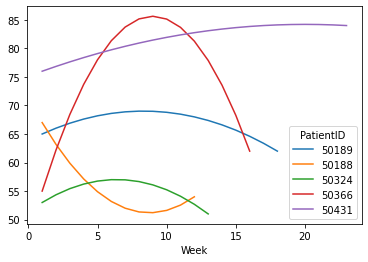

In [84]:
panss_by_time.iloc[:5].transpose().plot()

In [83]:
# linear or log? test Pearson Correlation
pids = pats.sample(5).index
f, axs = plt.subplots(2,1,sharex=True, figsize=(8,8))
for pid in pids:
    temp_df = df[(df.PatientID == pid) & (df.VisitDay < 140)]

    temp_df.plot(x='VisitDay', y='PANSS_Total',ax=axs[0])
    print(temp_df['VisitDay'].corr(temp_df['PANSS_Total']))
    temp_df.plot(x='VisitDay', y='log_PANSS',ax=axs[1])
    print(temp_df['VisitDay'].corr(temp_df['log_PANSS']))
    
axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)

NameError: name 'pats' is not defined

In [90]:
df

PatientID  VisitDay  PANSS_Total  log_PANSS
AssessmentID                                             
201211            20002         0           86   4.454347
201301            20002        22           82   4.406719
201518            20002        36           89   4.488636
201865            20002       148           80   4.382027
201615            20002       190           76   4.330733
...                 ...       ...          ...        ...
402930            40158        81           49   3.891820
400825            40158        91           47   3.850148
401333            40158       113           71   4.262680
401278            40158       197           70   4.248495
401307            40158       253           59   4.077537

[9660 rows x 4 columns]

In [25]:
df.groupby('PatientID').apply(len)

PatientID
10001    1
10002    3
10004    4
10005    9
10006    6
        ..
40215    1
40216    1
40218    2
40219    2
40222    8
Length: 2245, dtype: int64

In [27]:
get_reliable_patients(
    df, 
    nvisits=nvisits, 
    start_visit_day_threshold=10, 
    target_visit_day_threshold=18*7, 
    drop_extra_columns=False)

NameError: name 'nvisits' is not defined

#### Helper Functions

In [11]:
    
def plot_cluster_silhouette(models, X, algo):
    nrows = 2
    ncols = len(models) // 2 + 1 if len(models) % 2 else len(models) // 2
    f, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    plt.tight_layout()
    
    for model, ax in zip(models, axs.flatten()):
        y = model.labels_
        cluster_labels = np.unique(y)
        n_clusters = cluster_labels.shape[0]
        silhouette_vals = silhouette_samples(X, y, metric='euclidean')
        y_ax_lower, y_ax_upper = 0, 0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i) / n_clusters)
            ax.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                     edgecolor='none', color=color)

            yticks.append((y_ax_lower + y_ax_upper) / 2.)
            y_ax_lower += len(c_silhouette_vals)

        silhouette_avg = np.mean(silhouette_vals)
        ax.axvline(silhouette_avg, color="red", linestyle="--") 

        ax.set_title(f'K = {n_clusters}', fontsize=20)
        ax.set_yticklabels(cluster_labels + 1)
        ax.set_ylabel('')
        ax.set_xlabel('')

        #ax.savefig('csm_{}_{}.png'.format(algo, data_set_meta['data_set_name']), bbox_inches='tight')
        #ax.tight_layout()

    f.text(0.5, 0.04, 'Silhouette Coefficient', ha='center', fontsize=20)
    f.text(0.04, 0.5, 'Cluster', va='center', rotation='vertical', fontsize=20)
    plt.show()
def visualize_clusters(model, X_tsne):
    y_tsne = model.labels_
    n_clusters = len(set(y_tsne))
    cluster_labels = np.unique(y_tsne)

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    # plot the labeled clusters
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(set(y_tsne))))
    for label, color in zip(set(y_tsne), colors):
        axs.scatter(X_tsne[y_tsne==label, 0], X_tsne[y_tsne==label, 1], color=color,label=label, alpha=0.3);

    axs.set_title(f'n_clusters = {len(set(model.labels_))}', fontsize=16);
    axs.set_xlabel('Dim 1', fontsize=16);
    axs.set_ylabel('Dim 2', fontsize=16);
    axs.legend(loc='lower left');

def plot_csm(data_set_meta, models, X, algo):
    i = data_set_meta['best_k'] - data_set_meta['range_n_clusters'][0]
    model = models[i]
    y = model.labels_
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.title('CSM Plot of {} (K = {})'.format(data_set_meta['data_set_name'], n_clusters), fontsize=20)
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster', fontsize=20)
    plt.xlabel('Silhouette coefficient', fontsize=20)

    plt.savefig('csm_{}_{}.png'.format(algo, data_set_meta['data_set_name']), bbox_inches='tight')
    plt.tight_layout()
    plt.show()

Positive  Negative  General  Composite  PANSS_Total
0              26.77     17.95    42.75       8.82        87.47
1              21.87     23.35    44.99      -1.48        90.22
2              22.46     30.62    49.84      -8.17       102.92
3              15.66     25.31    39.02      -9.66        80.00
4              29.02     25.51    52.52       3.51       107.05
5              19.30     19.37    37.20      -0.07        75.86
population     21.61     23.10    43.17      -1.49        87.88

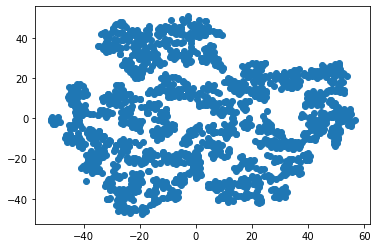

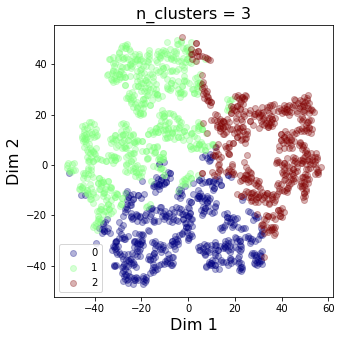

In [338]:
pca_n_components = pca_n_components_selection(df[sum_score_cols])

model_K3 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_n_components)),
    ('cluster', KMeans(
        n_clusters=3, 
        init='k-means++', 
        n_init=10, 
        max_iter=300,
        tol=1e-04,
        random_state=0
    ))
])

model_K3.fit(df[sum_score_cols])
_, X_tsne = visualize_data(df[sum_score_cols],pca_n_components=pca_n_components)
visualize_clusters(model_K3['cluster'], X_tsne)

In [352]:
df_sum_score_K3 = df[sum_score_cols].copy()
df_sum_score_K3['cluster_label'] = model_K3['cluster'].labels_
df_sum_score_K3.groupby('cluster_label').agg(['mean','std'])

Positive             Negative              General            \
                    mean       std       mean       std       mean       std   
cluster_label                                                                  
0              23.360656  3.530521  18.938069  2.866842  40.710383  4.770834   
1              17.163717  2.935754  23.874631  3.443647  39.716814  4.707646   
2              25.600775  3.836908  26.507752  3.541973  50.327519  4.874672   

              Composite           PANSS_Total            
                   mean       std        mean       std  
cluster_label                                            
0              4.422587  4.424954   83.009107  7.309747  
1             -6.710914  4.391703   80.755162  7.174688  
2             -0.906977  5.555988  102.436047  7.540298

In [353]:
df[sum_score_cols].agg(['mean','std'])

Positive   Negative    General  Composite  PANSS_Total
mean  21.613310  23.099254  43.170970  -1.485944    87.883534
std    5.000079   4.476102   6.672383   6.671452    11.984092

3


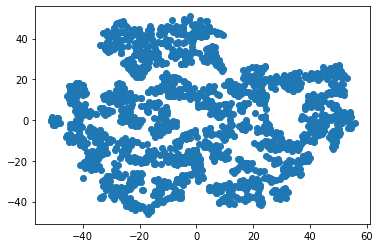

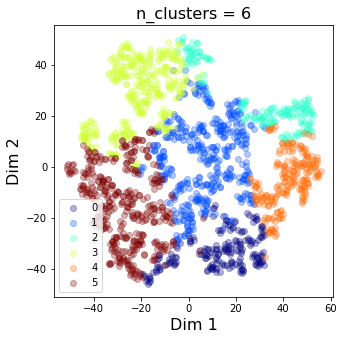

In [341]:
pca_n_components = pca_n_components_selection(df[sum_score_cols])

model_K6 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_n_components)),
    ('cluster', KMeans(
        n_clusters=6, 
        init='k-means++', 
        n_init=10, 
        max_iter=300,
        tol=1e-04,
        random_state=0
    ))
])

model_K6.fit(df[sum_score_cols])
_, X_tsne = visualize_data(df[sum_score_cols],pca_n_components=pca_n_components)
visualize_clusters(model_K6['cluster'], X_tsne)


In [369]:
df_sum_score.reset_index()

PatientID  Positive  Negative   General  Composite  PANSS_Total  \
0         10002   0.59375  0.290323  0.500000   0.660377     0.435294   
1         10004   0.59375  0.548387  0.541667   0.509434     0.552941   
2         10005   0.59375  0.451613  0.666667   0.566038     0.588235   
3         10006   0.68750  0.516129  0.812500   0.584906     0.729412   
4         10007   0.78125  0.677419  0.645833   0.547170     0.729412   
...         ...       ...       ...       ...        ...          ...   
1738      40190   0.40625  0.451613  0.645833   0.452830     0.505882   
1739      40195   0.50000  0.741935  0.750000   0.339623     0.705882   
1740      40196   0.59375  0.451613  0.666667   0.566038     0.588235   
1741      40207   0.40625  0.193548  0.395833   0.603774     0.270588   
1742      40222   0.53125  0.161290  0.520833   0.698113     0.376471   

      cluster_label  
0                 0  
1                 1  
2                 4  
3                 4  
4                 4  
...             ...  
1738              1  
1739              2  
1740              4  
1741              5  
1742              0  

[1743 rows x 7 columns]

In [373]:
pd.melt(
    df_sum_score.reset_index(),
    id_vars=['PatientID', 'cluster_label'], 
    value_vars=['Positive', 'Negative', 'General', 'Composite','PANSS_Total'],
    var_name='Attribute',
    value_name='Value'
)

PatientID  cluster_label    Attribute     Value
0         10002              0     Positive  0.593750
1         10004              1     Positive  0.593750
2         10005              4     Positive  0.593750
3         10006              4     Positive  0.687500
4         10007              4     Positive  0.781250
...         ...            ...          ...       ...
8710      40190              1  PANSS_Total  0.505882
8711      40195              2  PANSS_Total  0.705882
8712      40196              4  PANSS_Total  0.588235
8713      40207              5  PANSS_Total  0.270588
8714      40222              0  PANSS_Total  0.376471

[8715 rows x 4 columns]

Positive   Negative    General  Composite  PANSS_Total
0           26.768116  17.946860  42.753623   8.821256    87.468599
1           21.873563  23.349425  44.993103  -1.475862    90.216092
2           22.455090  30.622754  49.844311  -8.167665   102.922156
3           15.658385  25.313665  39.024845  -9.655280    79.996894
4           29.024155  25.512077  52.516908   3.512077   107.053140
5           19.298765  19.367901  37.195062  -0.069136    75.861728
population  21.613310  23.099254  43.170970  -1.485944    87.883534

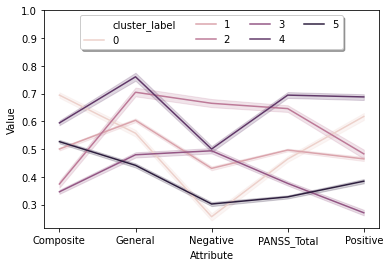

In [422]:

scaler = MinMaxScaler()
# Normalization
df_normlized = pd.DataFrame(
    scaler.fit_transform(df[sum_score_cols]), 
    columns=df[sum_score_cols].columns,
    index=df[sum_score_cols].index
)

df_normlized['cluster_label'] = model_K6['cluster'].labels_

df_melted = pd.melt(
    df_normlized.reset_index(),
    id_vars=['PatientID', 'cluster_label'], 
    value_vars=['Positive', 'Negative', 'General', 'Composite','PANSS_Total'],
    var_name='Attribute',
    value_name='Value'
)
sns.lineplot(
    x='Attribute',
    y='Value',
    hue='cluster_label',
    data=df_melted,
    legend='full',
    markers=True
)
plt.ylim(top=1)
plt.legend(loc='upper center', ncol=4, fancybox=True, shadow=True)



df_sum_score = df[sum_score_cols].copy()
df_sum_score['cluster_label'] = model_K6['cluster'].labels_
grouped = df_sum_score.groupby('cluster_label').agg('mean')
grouped.append(df[sum_score_cols].agg('mean').to_frame().rename(columns={0:'population'}).transpose())

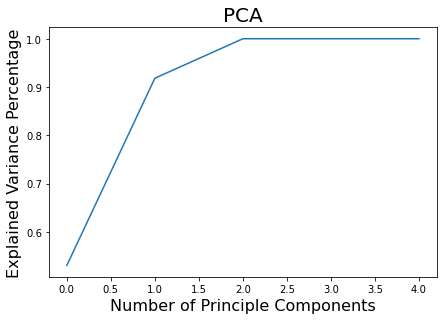

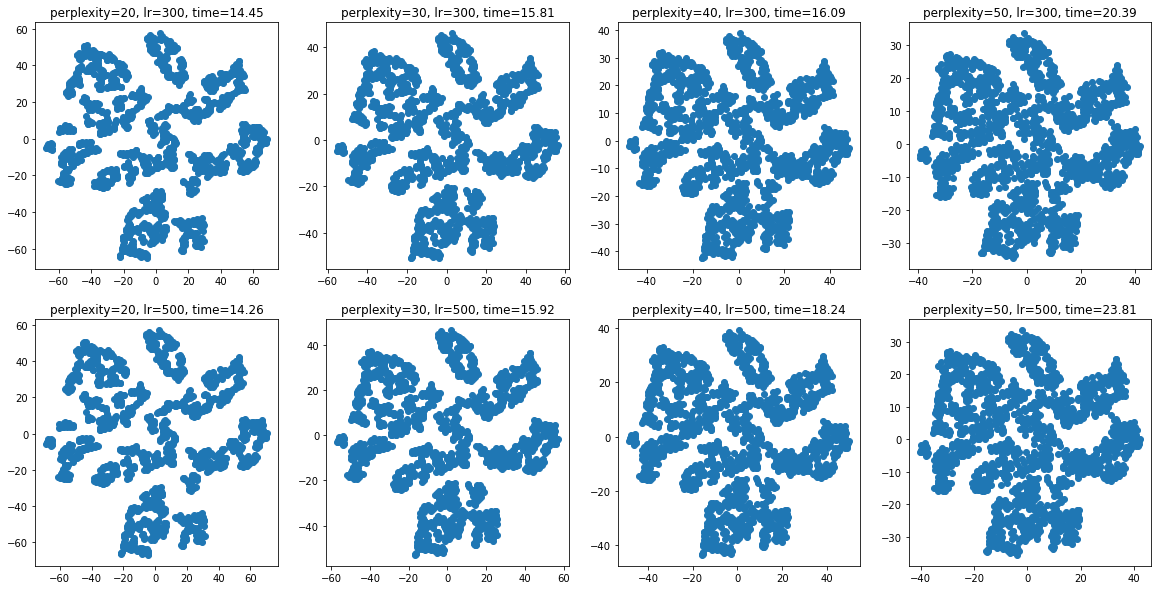

In [300]:
scaler = StandardScaler()
pca = PCA(n_components=pca_n_components_selection(df[sum_score_cols],show_fig=True))
print(pca_n_components_selection(df[sum_score_cols]))
X = scaler.fit_transform(df[sum_score_cols])
X = pca.fit_transform(X)


perplexities = [20, 30, 40, 50]
learning_rates = [300, 500]

fig, axs = plt.subplots(len(learning_rates), len(perplexities), figsize=(20,10))


for i, lr in enumerate(learning_rates):
    for j, perplex in enumerate(perplexities):
        
        tic = time.time()
        tsne = TSNE(
            n_components=2, 
            init='pca', 
            perplexity=perplex,
            learning_rate=lr,
            n_iter=1000,
            random_state=42,
            verbose=0,
            n_jobs=-1
        )
        X_temp = tsne.fit_transform(X)
        toc = time.time()

        axs[i, j].set_title(f'perplexity={perplex}, lr={lr}, time={toc-tic:.2f}')
        axs[i, j].scatter(X_temp[:, 0], X_temp[:, 1])
        axs[i, j].axis('tight')

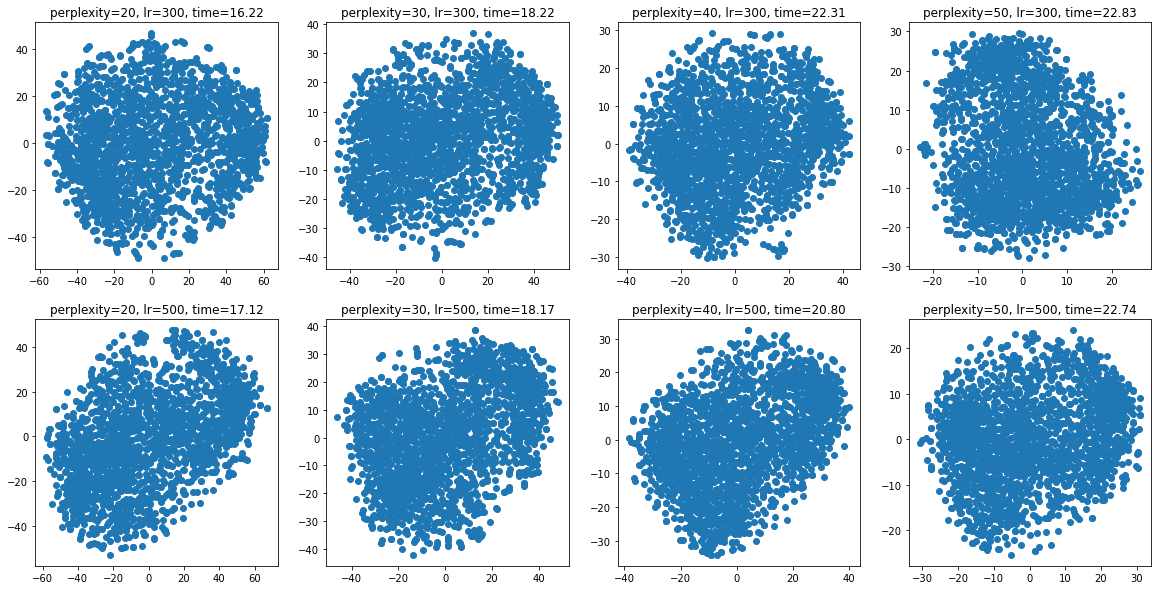

In [29]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

perplexities = [20, 30, 40, 50]
learning_rates = [300, 500]

fig, axs = plt.subplots(len(learning_rates), len(perplexities), figsize=(20,10))


for i, lr in enumerate(learning_rates):
    for j, perplex in enumerate(perplexities):
        
        tic = time.time()
        tsne = TSNE(
            n_components=2, 
            init='pca', 
            perplexity=perplex,
            learning_rate=lr,
            n_iter=1000,
            random_state=42,
            verbose=0,
            n_jobs=-1
        )
        X_temp = tsne.fit_transform(X)
        toc = time.time()

        axs[i, j].set_title(f'perplexity={perplex}, lr={lr}, time={toc-tic:.2f}')
        axs[i, j].scatter(X_temp[:, 0], X_temp[:, 1])
        axs[i, j].axis('tight')

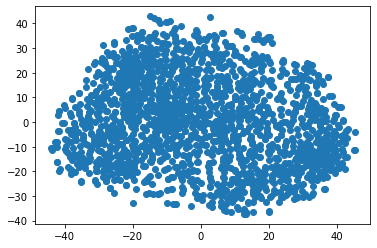

In [285]:
def visualize_data(df, pca_n_components=None, tsne_n_components=2):    
    tsne = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_n_components)),
        ('tsne', TSNE(
            n_components=tsne_n_components, 
            init='pca', 
            perplexity=30,
            learning_rate=300,
            n_iter=1000,
            random_state=42,
            verbose=0,
            n_jobs=-1
        ))
    ])

    X_tsne = tsne.fit_transform(df)
    plt.scatter(X_tsne[:,0], X_tsne[:,1]);
    return tsne, X_tsne

_, X_tsne = visualize_data(df)

In [430]:

def visualize_clusters(model, X_tsne):
    y_tsne = model.labels_
    n_clusters = len(set(y_tsne))
    cluster_labels = np.unique(y_tsne)

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    # plot the labeled clusters
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(set(y_tsne))))
    for label, color in zip(set(y_tsne), colors):
        axs.scatter(X_tsne[y_tsne==label, 0], X_tsne[y_tsne==label, 1], color=color,label=label, alpha=0.3);

    axs.set_title(f'n_clusters = {len(set(model.labels_))}', fontsize=16);
    axs.set_xlabel('Dim 1', fontsize=16);
    axs.set_ylabel('Dim 2', fontsize=16);
    axs.legend(loc='lower left');

def plot_csm(data_set_meta, models, X, algo):
    i = data_set_meta['best_k'] - data_set_meta['range_n_clusters'][0]
    model = models[i]
    y = model.labels_
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.title('CSM Plot of {} (K = {})'.format(data_set_meta['data_set_name'], n_clusters), fontsize=20)
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster', fontsize=20)
    plt.xlabel('Silhouette coefficient', fontsize=20)

    plt.savefig('csm_{}_{}.png'.format(algo, data_set_meta['data_set_name']), bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    
def plot_cluster_silhouette(models, X, algo):
    nrows = 2
    ncols = len(models) // 2 + 1 if len(models) % 2 else len(models) // 2
    f, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    
    for model, ax in zip(models, axs.flatten()):
        y = model.labels_
        cluster_labels = np.unique(y)
        n_clusters = cluster_labels.shape[0]
        silhouette_vals = silhouette_samples(X, y, metric='euclidean')
        y_ax_lower, y_ax_upper = 0, 0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i) / n_clusters)
            ax.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                     edgecolor='none', color=color)

            yticks.append((y_ax_lower + y_ax_upper) / 2.)
            y_ax_lower += len(c_silhouette_vals)

        silhouette_avg = np.mean(silhouette_vals)
        ax.axvline(silhouette_avg, color="red", linestyle="--") 

        ax.set_title(f'K = {n_clusters}', fontsize=20)
        ax.set_yticklabels(cluster_labels + 1)
        ax.set_ylabel('')
        ax.set_xlabel('')

        #ax.savefig('csm_{}_{}.png'.format(algo, data_set_meta['data_set_name']), bbox_inches='tight')
        #ax.tight_layout()

    f.text(0.5, 0.04, 'Silhouette Coefficient', ha='center', fontsize=20)
    f.text(0.04, 0.5, 'Cluster', va='center', rotation='vertical', fontsize=20)
    plt.show()

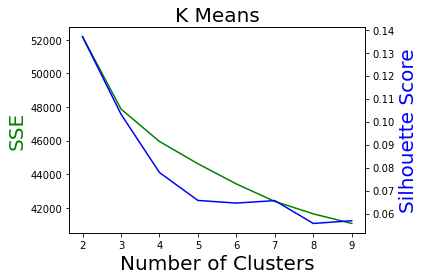

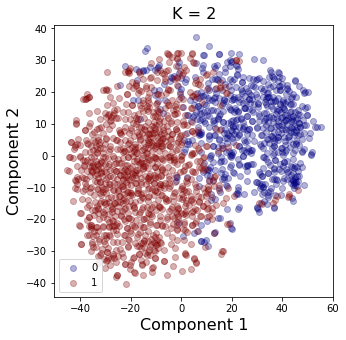

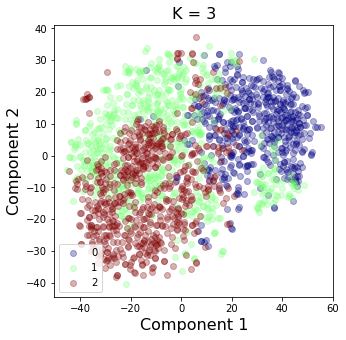

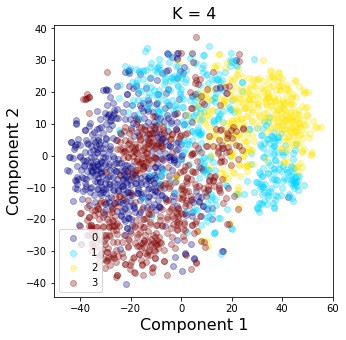

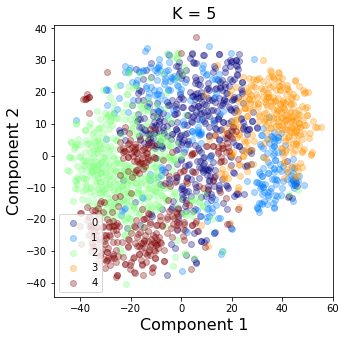

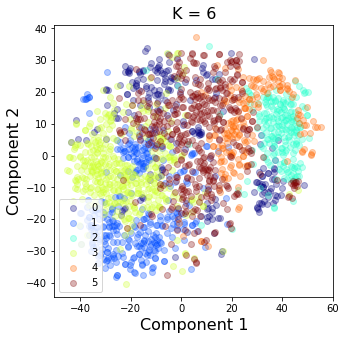

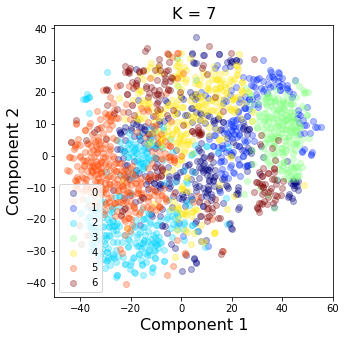

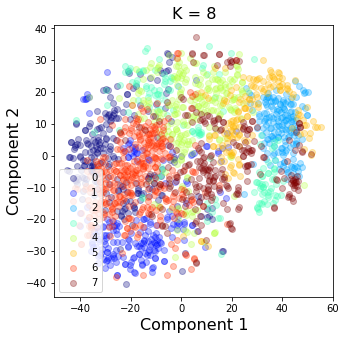

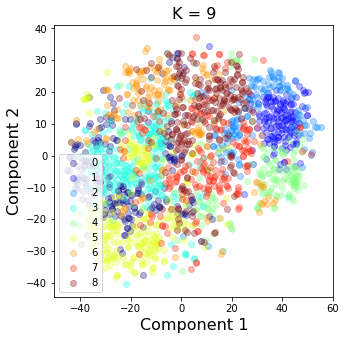

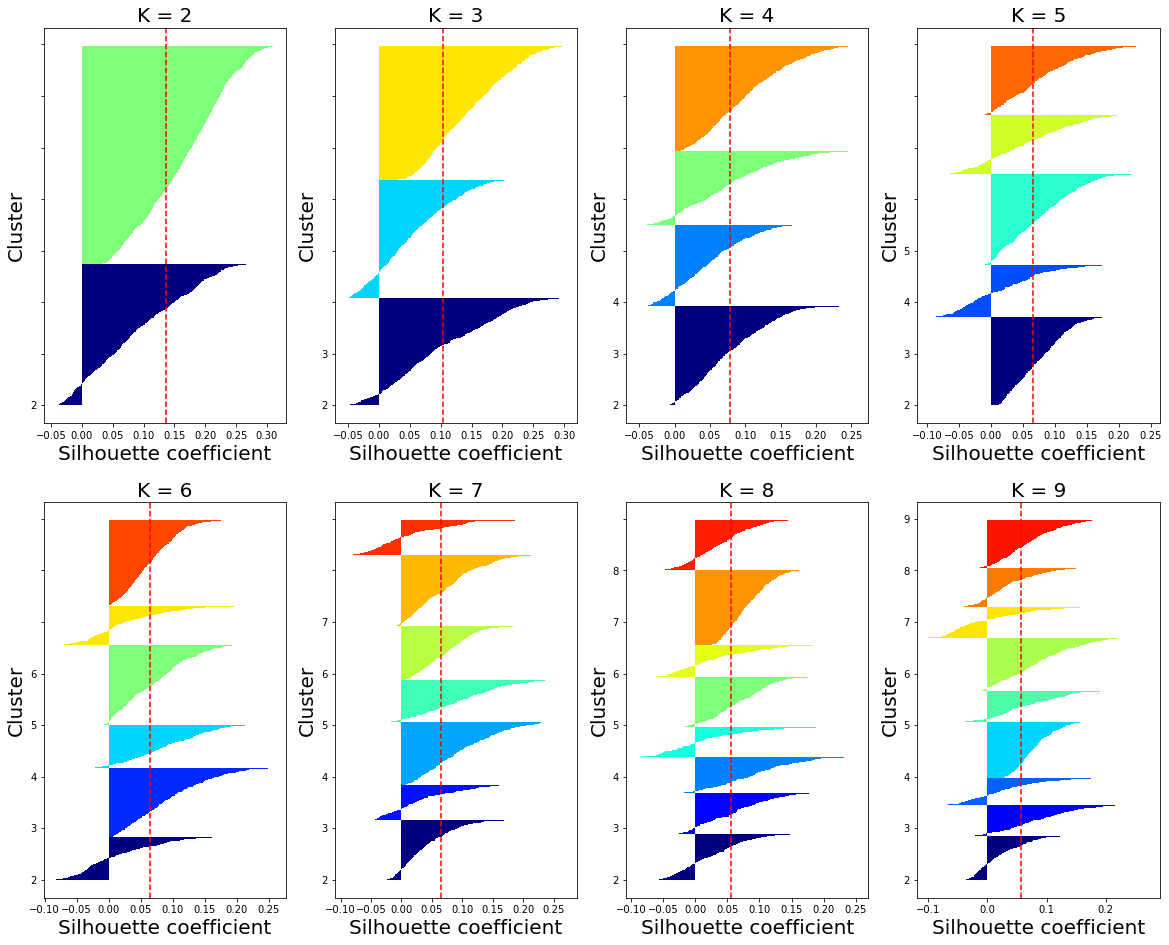

In [245]:

precessor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_n_components))
])

X = precessor.fit_transform(df)

range_n_clusters = range(2, 10)
models = []
sse = []
cms = []
for n_clusters in range_n_clusters:
    model = KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=42
    )

    model = model.fit(X)

    models.append(model)
    sse.append(model.inertia_)
    cms.append(silhouette_score(X, model.labels_, metric='euclidean'))

    
algo = 'K Means'

# Find the optimal K: Elbow Method
fig, ax1 = plt.subplots();

ax2 = ax1.twinx()
ax1.plot(range_n_clusters, sse, 'g-')
ax2.plot(range_n_clusters, cms, 'b-')

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.set_ylabel('SSE', fontsize=20, color='g')
ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
ax1.set_title(f'{algo}', fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('clustering.jpg', bbox_inches = 'tight');


for model in models:
    visualize_clusters(model, X_tsne)
    
plot_cluster_silhouette(models, X, 'K Means')

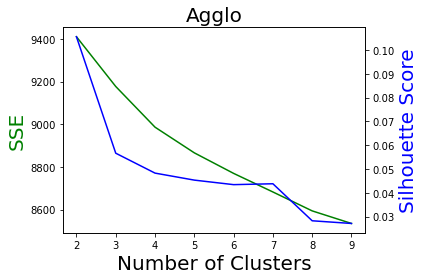

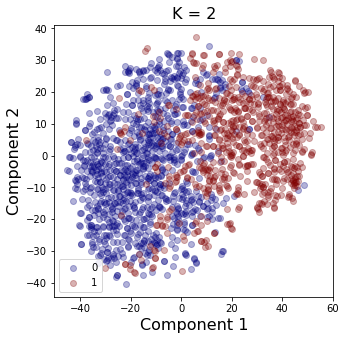

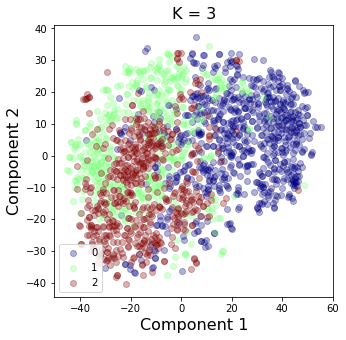

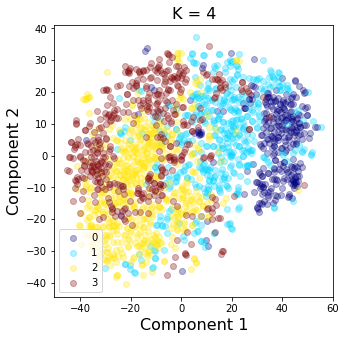

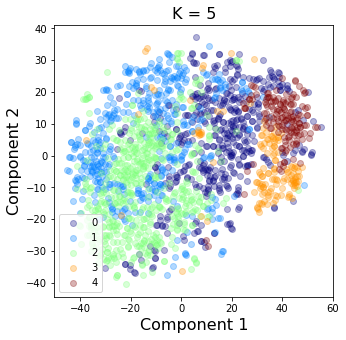

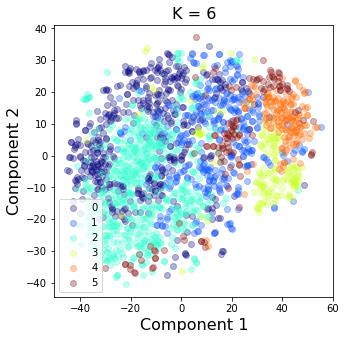

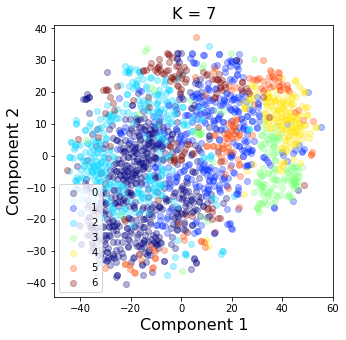

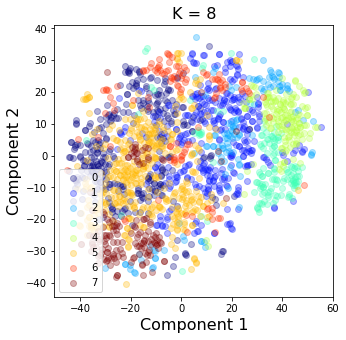

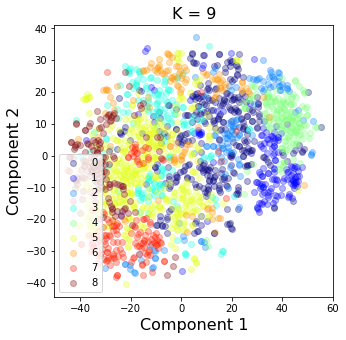

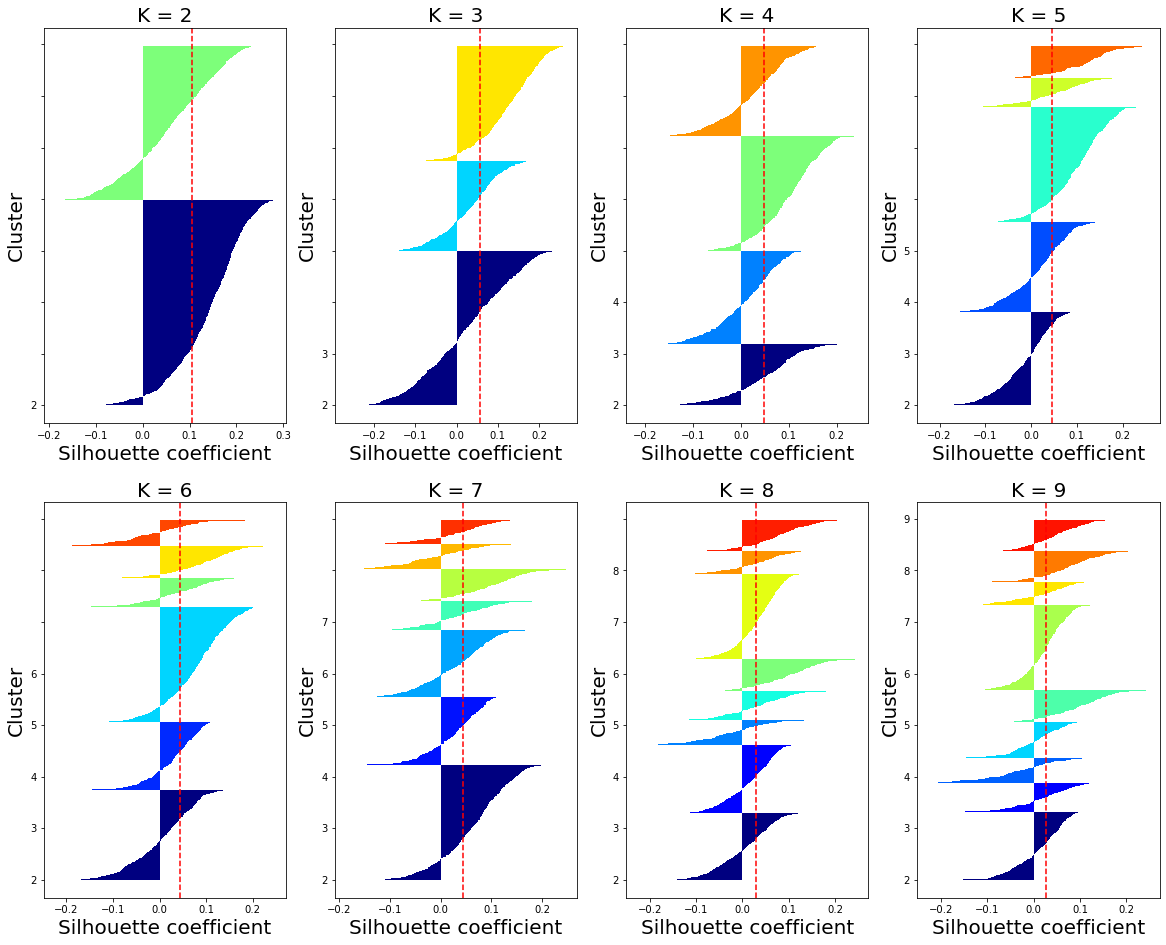

In [244]:
n_components = 29
precessor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components))
])

X = precessor.fit_transform(df)

range_n_clusters = range(2, 10)
models = []
sse = []
cms = []
for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity='euclidean', 
        linkage='ward'       
    )

    model = model.fit(X)
    
    y = model.labels_
    # calculate SSE
    sse_temp = 0
    for label in range(model.n_clusters_):
        X_group = X[y == label]
        centroid = X_group.mean(axis=0).reshape(1,-1)
        sse_temp += pairwise_distances(X_group, centroid, metric='euclidean').sum()

    models.append(model)
    sse.append(sse_temp)
    cms.append(silhouette_score(X, y, metric='euclidean'))

    
algo = 'Agglo'

# Find the optimal K: Elbow Method
fig, ax1 = plt.subplots();

ax2 = ax1.twinx()
ax1.plot(range_n_clusters, sse, 'g-')
ax2.plot(range_n_clusters, cms, 'b-')

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.set_ylabel('SSE', fontsize=20, color='g')
ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
ax1.set_title(f'{algo}', fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('clustering.jpg', bbox_inches = 'tight');

for model in models:
    visualize_clusters(model, X_tsne)
    
plot_cluster_silhouette(models, X, 'Agglo Clustering')

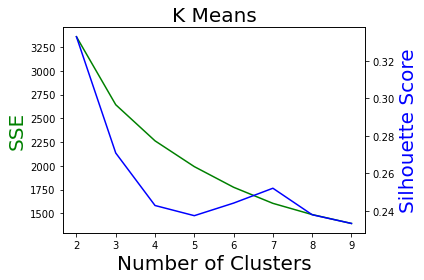

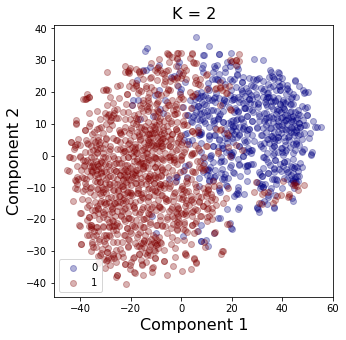

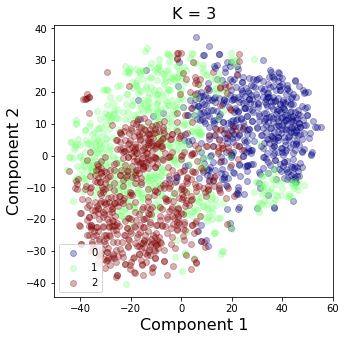

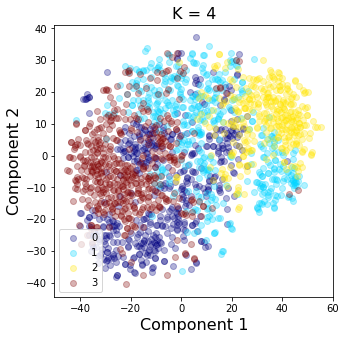

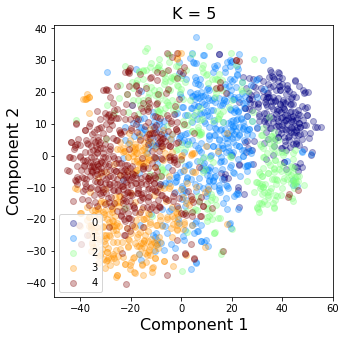

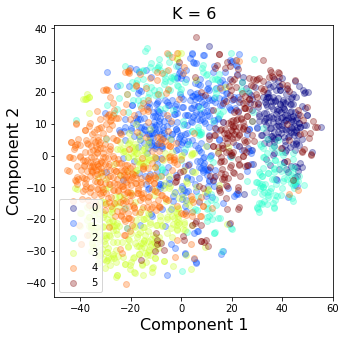

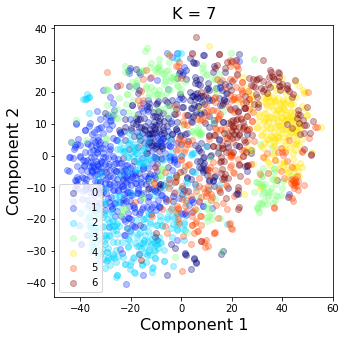

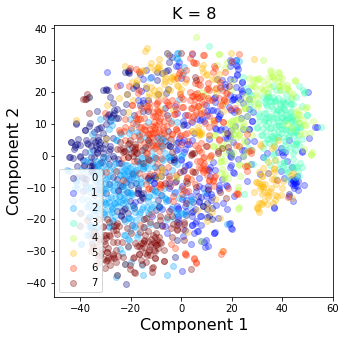

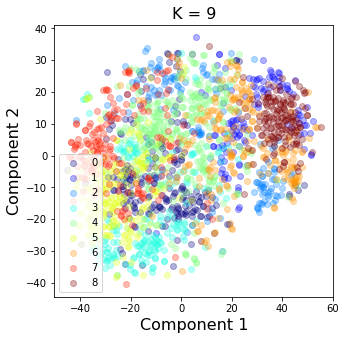

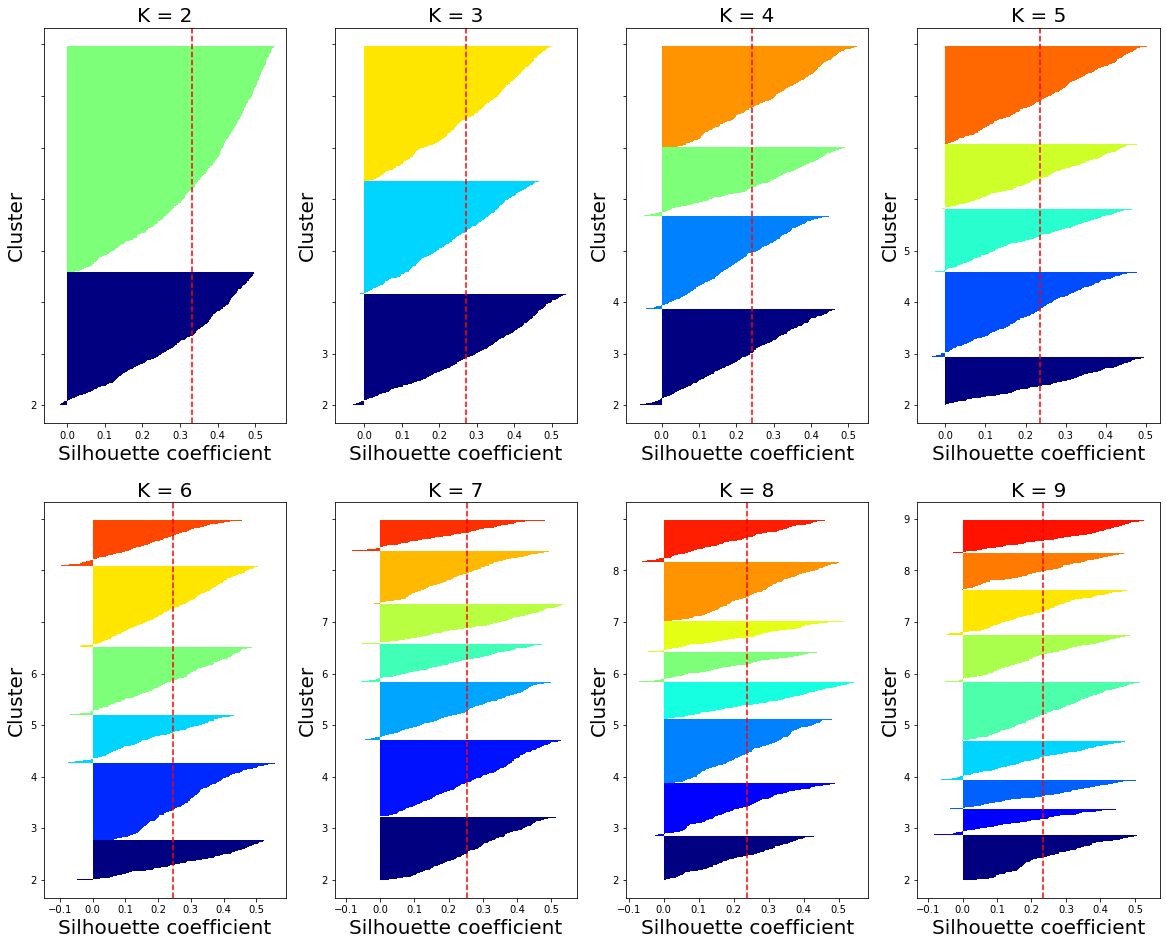

In [243]:

precessor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

X = precessor.fit_transform(df[['Positive', 'Negative', 'General']])

range_n_clusters = range(2, 10)
models = []
sse = []
cms = []
for n_clusters in range_n_clusters:
    model = KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=42
    )

    model = model.fit(X)

    models.append(model)
    sse.append(model.inertia_)
    cms.append(silhouette_score(X, model.labels_, metric='euclidean'))

    
algo = 'K Means'

# Find the optimal K: Elbow Method
fig, ax1 = plt.subplots();

ax2 = ax1.twinx()
ax1.plot(range_n_clusters, sse, 'g-')
ax2.plot(range_n_clusters, cms, 'b-')

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.set_ylabel('SSE', fontsize=20, color='g')
ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
ax1.set_title(f'{algo}', fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('clustering.jpg', bbox_inches = 'tight');


for model in models:
    visualize_clusters(model, X_tsne)
plot_cluster_silhouette(models, X, 'K Means')

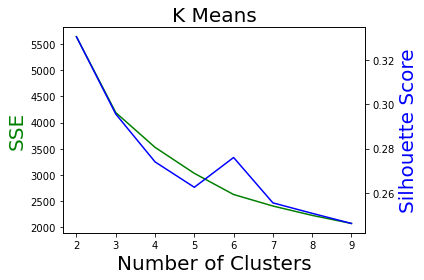

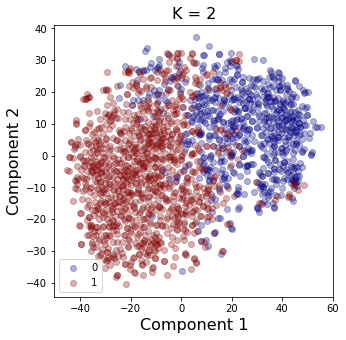

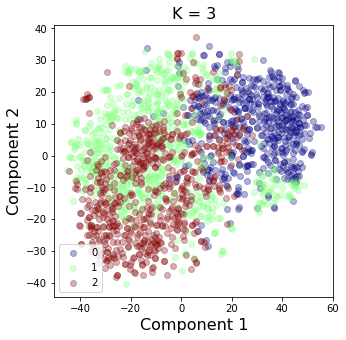

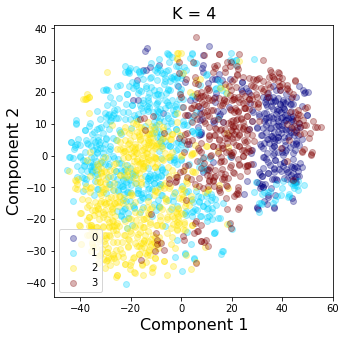

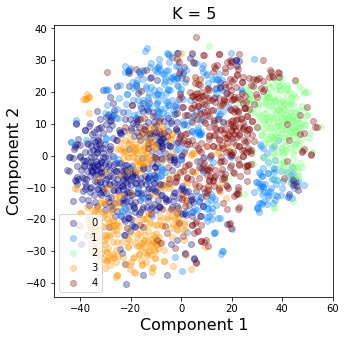

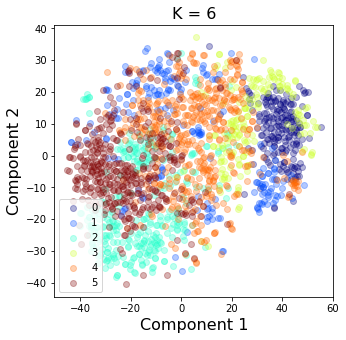

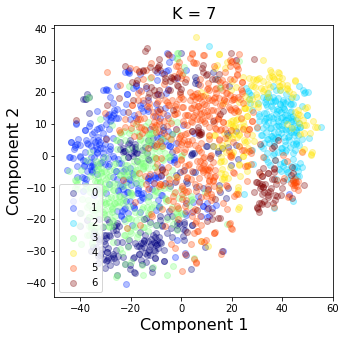

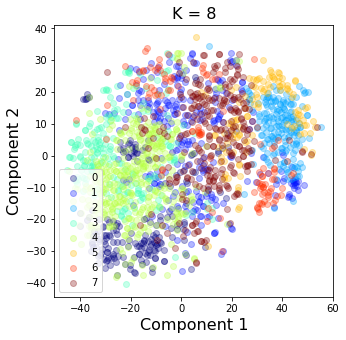

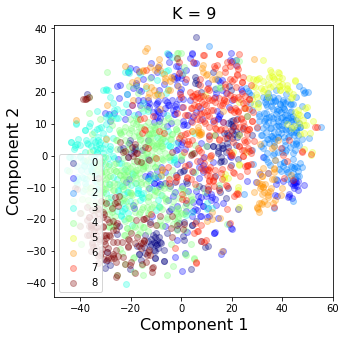

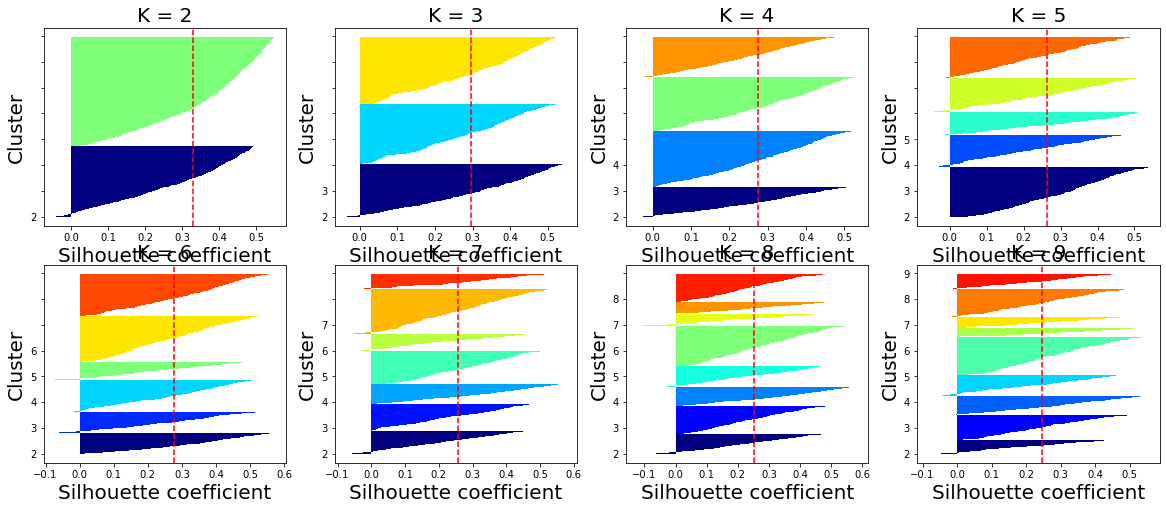

In [247]:

precessor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

X = precessor.fit_transform(df[sum_score_cols])

range_n_clusters = range(2, 10)
models = []
sse = []
cms = []
for n_clusters in range_n_clusters:
    model = KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=42
    )

    model = model.fit(X)

    models.append(model)
    sse.append(model.inertia_)
    cms.append(silhouette_score(X, model.labels_, metric='euclidean'))

    
algo = 'K Means'

# Find the optimal K: Elbow Method
fig, ax1 = plt.subplots();

ax2 = ax1.twinx()
ax1.plot(range_n_clusters, sse, 'g-')
ax2.plot(range_n_clusters, cms, 'b-')

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.set_ylabel('SSE', fontsize=20, color='g')
ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
ax1.set_title(f'{algo}', fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('clustering.jpg', bbox_inches = 'tight');


for model in models:
    visualize_clusters(model, X_tsne)
plot_cluster_silhouette(models, X, 'K Means')

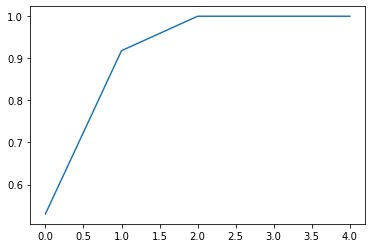

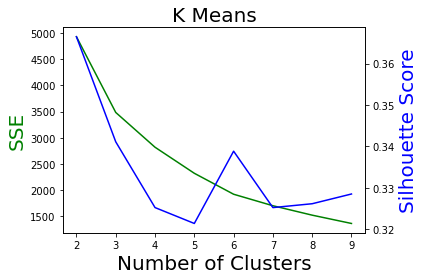

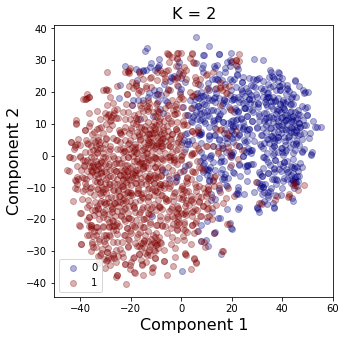

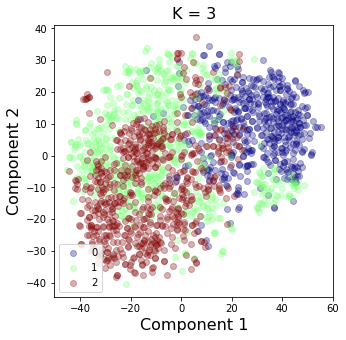

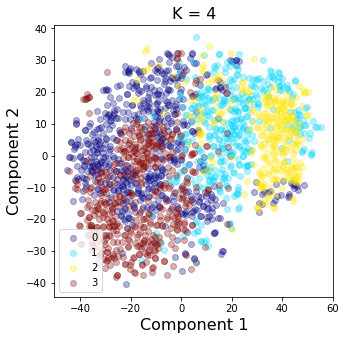

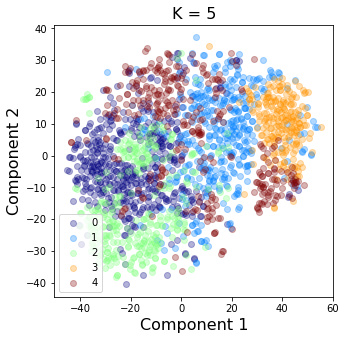

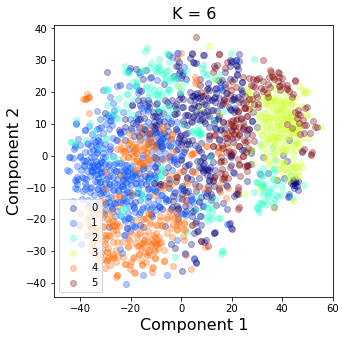

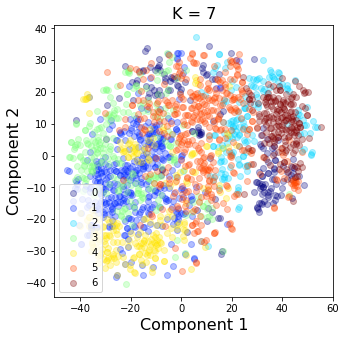

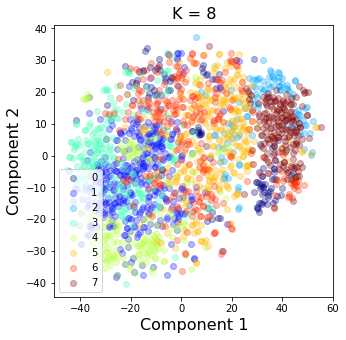

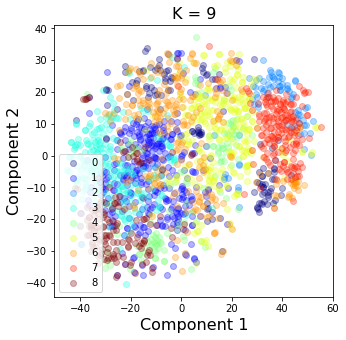

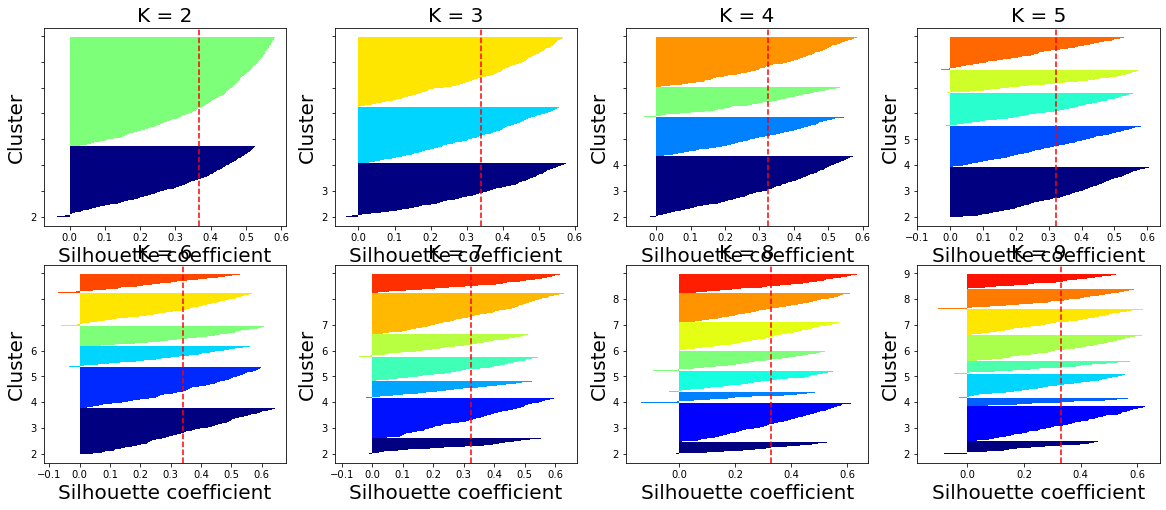

In [251]:

precessor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(pca_n_components_selection(df[sum_score_cols])))
])

X = precessor.fit_transform(df[sum_score_cols])

range_n_clusters = range(2, 10)
models = []
sse = []
cms = []
for n_clusters in range_n_clusters:
    model = KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=42
    )

    model = model.fit(X)

    models.append(model)
    sse.append(model.inertia_)
    cms.append(silhouette_score(X, model.labels_, metric='euclidean'))

    
algo = 'K Means'

# Find the optimal K: Elbow Method
fig, ax1 = plt.subplots();

ax2 = ax1.twinx()
ax1.plot(range_n_clusters, sse, 'g-')
ax2.plot(range_n_clusters, cms, 'b-')

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.set_ylabel('SSE', fontsize=20, color='g')
ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
ax1.set_title(f'{algo}', fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('clustering.jpg', bbox_inches = 'tight');


for model in models:
    visualize_clusters(model, X_tsne)
plot_cluster_silhouette(models, X, 'K Means')

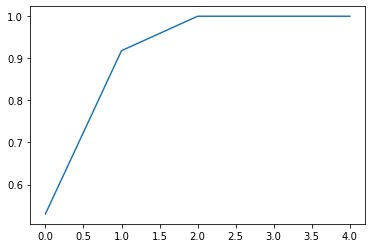

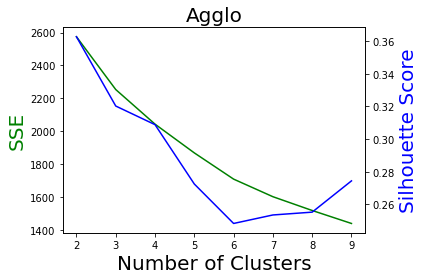

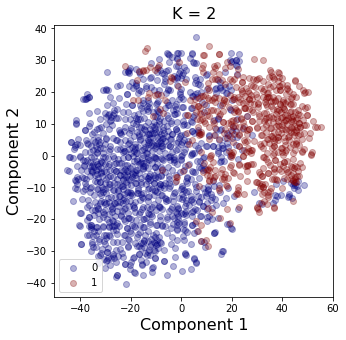

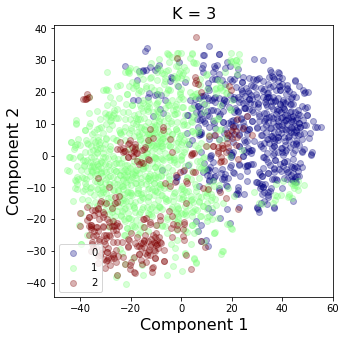

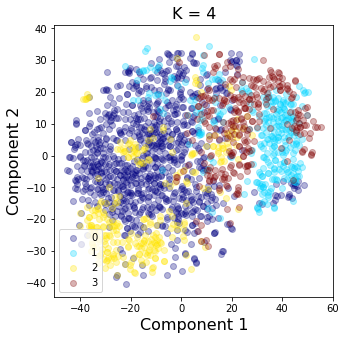

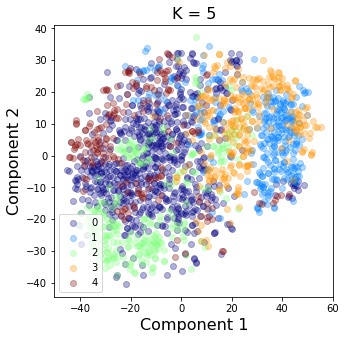

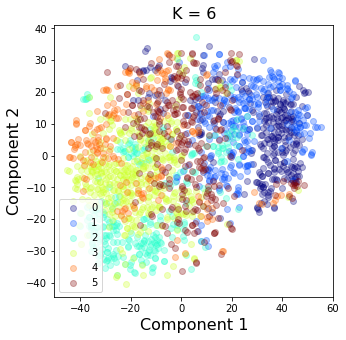

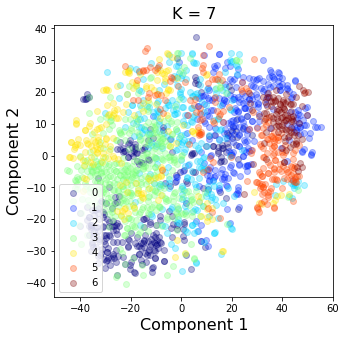

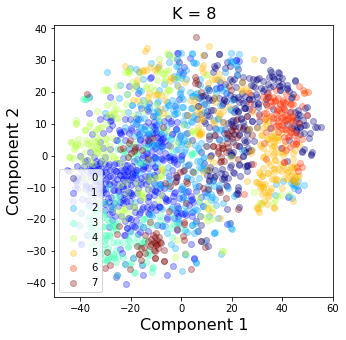

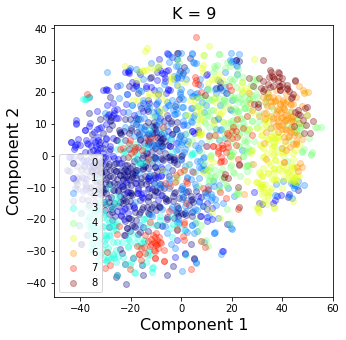

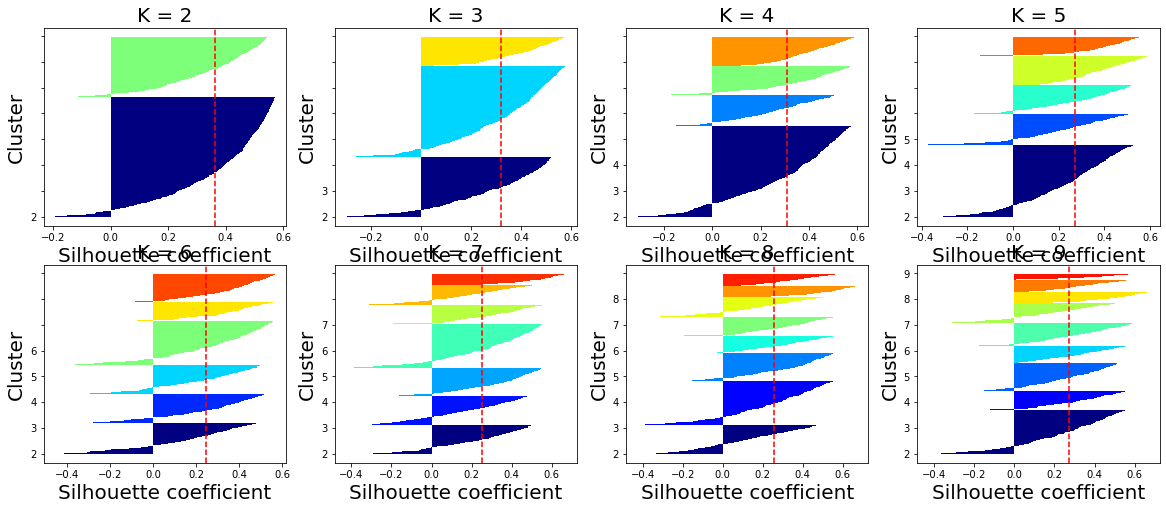

In [252]:

precessor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(pca_n_components_selection(df[sum_score_cols])))
])

X = precessor.fit_transform(df[sum_score_cols])

range_n_clusters = range(2, 10)
models = []
sse = []
cms = []
for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity='euclidean', 
        linkage='ward'       
    )

    model = model.fit(X)
    
    y = model.labels_
    # calculate SSE
    sse_temp = 0
    for label in range(model.n_clusters_):
        X_group = X[y == label]
        centroid = X_group.mean(axis=0).reshape(1,-1)
        sse_temp += pairwise_distances(X_group, centroid, metric='euclidean').sum()

    models.append(model)
    sse.append(sse_temp)
    cms.append(silhouette_score(X, y, metric='euclidean'))

    
algo = 'Agglo'

# Find the optimal K: Elbow Method
fig, ax1 = plt.subplots();

ax2 = ax1.twinx()
ax1.plot(range_n_clusters, sse, 'g-')
ax2.plot(range_n_clusters, cms, 'b-')

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.set_ylabel('SSE', fontsize=20, color='g')
ax2.set_ylabel('Silhouette Score', fontsize=20, color='b')
ax1.set_title(f'{algo}', fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('clustering.jpg', bbox_inches = 'tight');

for model in models:
    visualize_clusters(model, X_tsne)
plot_cluster_silhouette(models, X, 'Agglo Clustering')